# CIV Analysis

This is a notebook to be used after happy with the voigt profiling and like the column densites that were calculated 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 11,
          'xtick.minor.size': 7,
          'ytick.major.size': 11,
          'ytick.minor.size': 7}
plt.rcParams.update(params)

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

In [33]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')

TL;DR
- up_ch = upper limits 
- sum_df = summed values no up lims (USE FOR EVERYTHING BUT VEL PLOT) 
- com_df = comp values no up lims (USE ONLY FOR VEL PLOT)

In [34]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.65,0.05,0.0,0.0,0.0,0.0,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,1550.781,0.001494,13.50,0.05,0.0,0.0,0.0,0.0,1,0
11,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,1550.781,0.003809,13.38,0.05,0.0,0.0,0.0,0.0,1,0


In [37]:
#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
4,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.00000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1


In [38]:
#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = ch_df.loc[(ch_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
com_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.00223,13.403,0.099,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.00330,13.697,0.074,80.715,17.306,-9.444,12.162,1,1
5,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1548.204,0.00051,13.855,0.052,34.300,6.220,11.655,3.925,0,1
6,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,62.794963,...,1548.204,0.00081,13.652,0.103,10.925,4.852,-2.260,2.533,0,1
7,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,29.956925,...,1548.204,0.00109,13.946,0.044,30.000,4.293,-11.070,2.849,0,1
8,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.00442,13.990,0.057,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.00275,14.012,0.076,85.000,17.787,-21.098,12.763,1,1
10,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,1548.204,0.00422,14.211,0.053,54.100,7.973,18.210,5.687,1,1


In [49]:
#M31 Data (Project AMIGA) Detections (and taking out the MS contaminations) 

amiga_2_det_sum = pd.read_csv('/Users/samgarza/Documents/Sam_COSHoles_Analysis/amiga_2_det_sum.csv')
amiga_2_det_sum = amiga_2_det_sum.loc[(amiga_2_det_sum['sumlogN']!= 0)]
amiga_2_det_sum = amiga_2_det_sum.loc[amiga_2_det_sum['MS']==0]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
#making sure to use r200 as a substitute for since that is what we used 
amiga_m31_rvrir = 230 #kpc This is the value used for R200 in the paper? 

amiga_det_R = np.array(amiga_2_det_sum['Rad'])
amiga_det_RRvir = amiga_det_R/amiga_m31_rvrir

#amiga_2_det_sum

In [50]:
#M31 Data (Project AMIGA) non-detections (upper limits) and taking out the MS contamination
amiga_2_up_sum = pd.read_csv('/Users/samgarza/Documents/Sam_COSHoles_Analysis/amiga_2_up_sum.csv')
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['sumlogN']!= 0)]
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['MS']== 0)]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
amiga_up_R = np.array(amiga_2_up_sum['Rad'])
amiga_up_RRvir = amiga_up_R/amiga_m31_rvrir

#amiga_2_up_sum

## Galaxy Parameter Plots

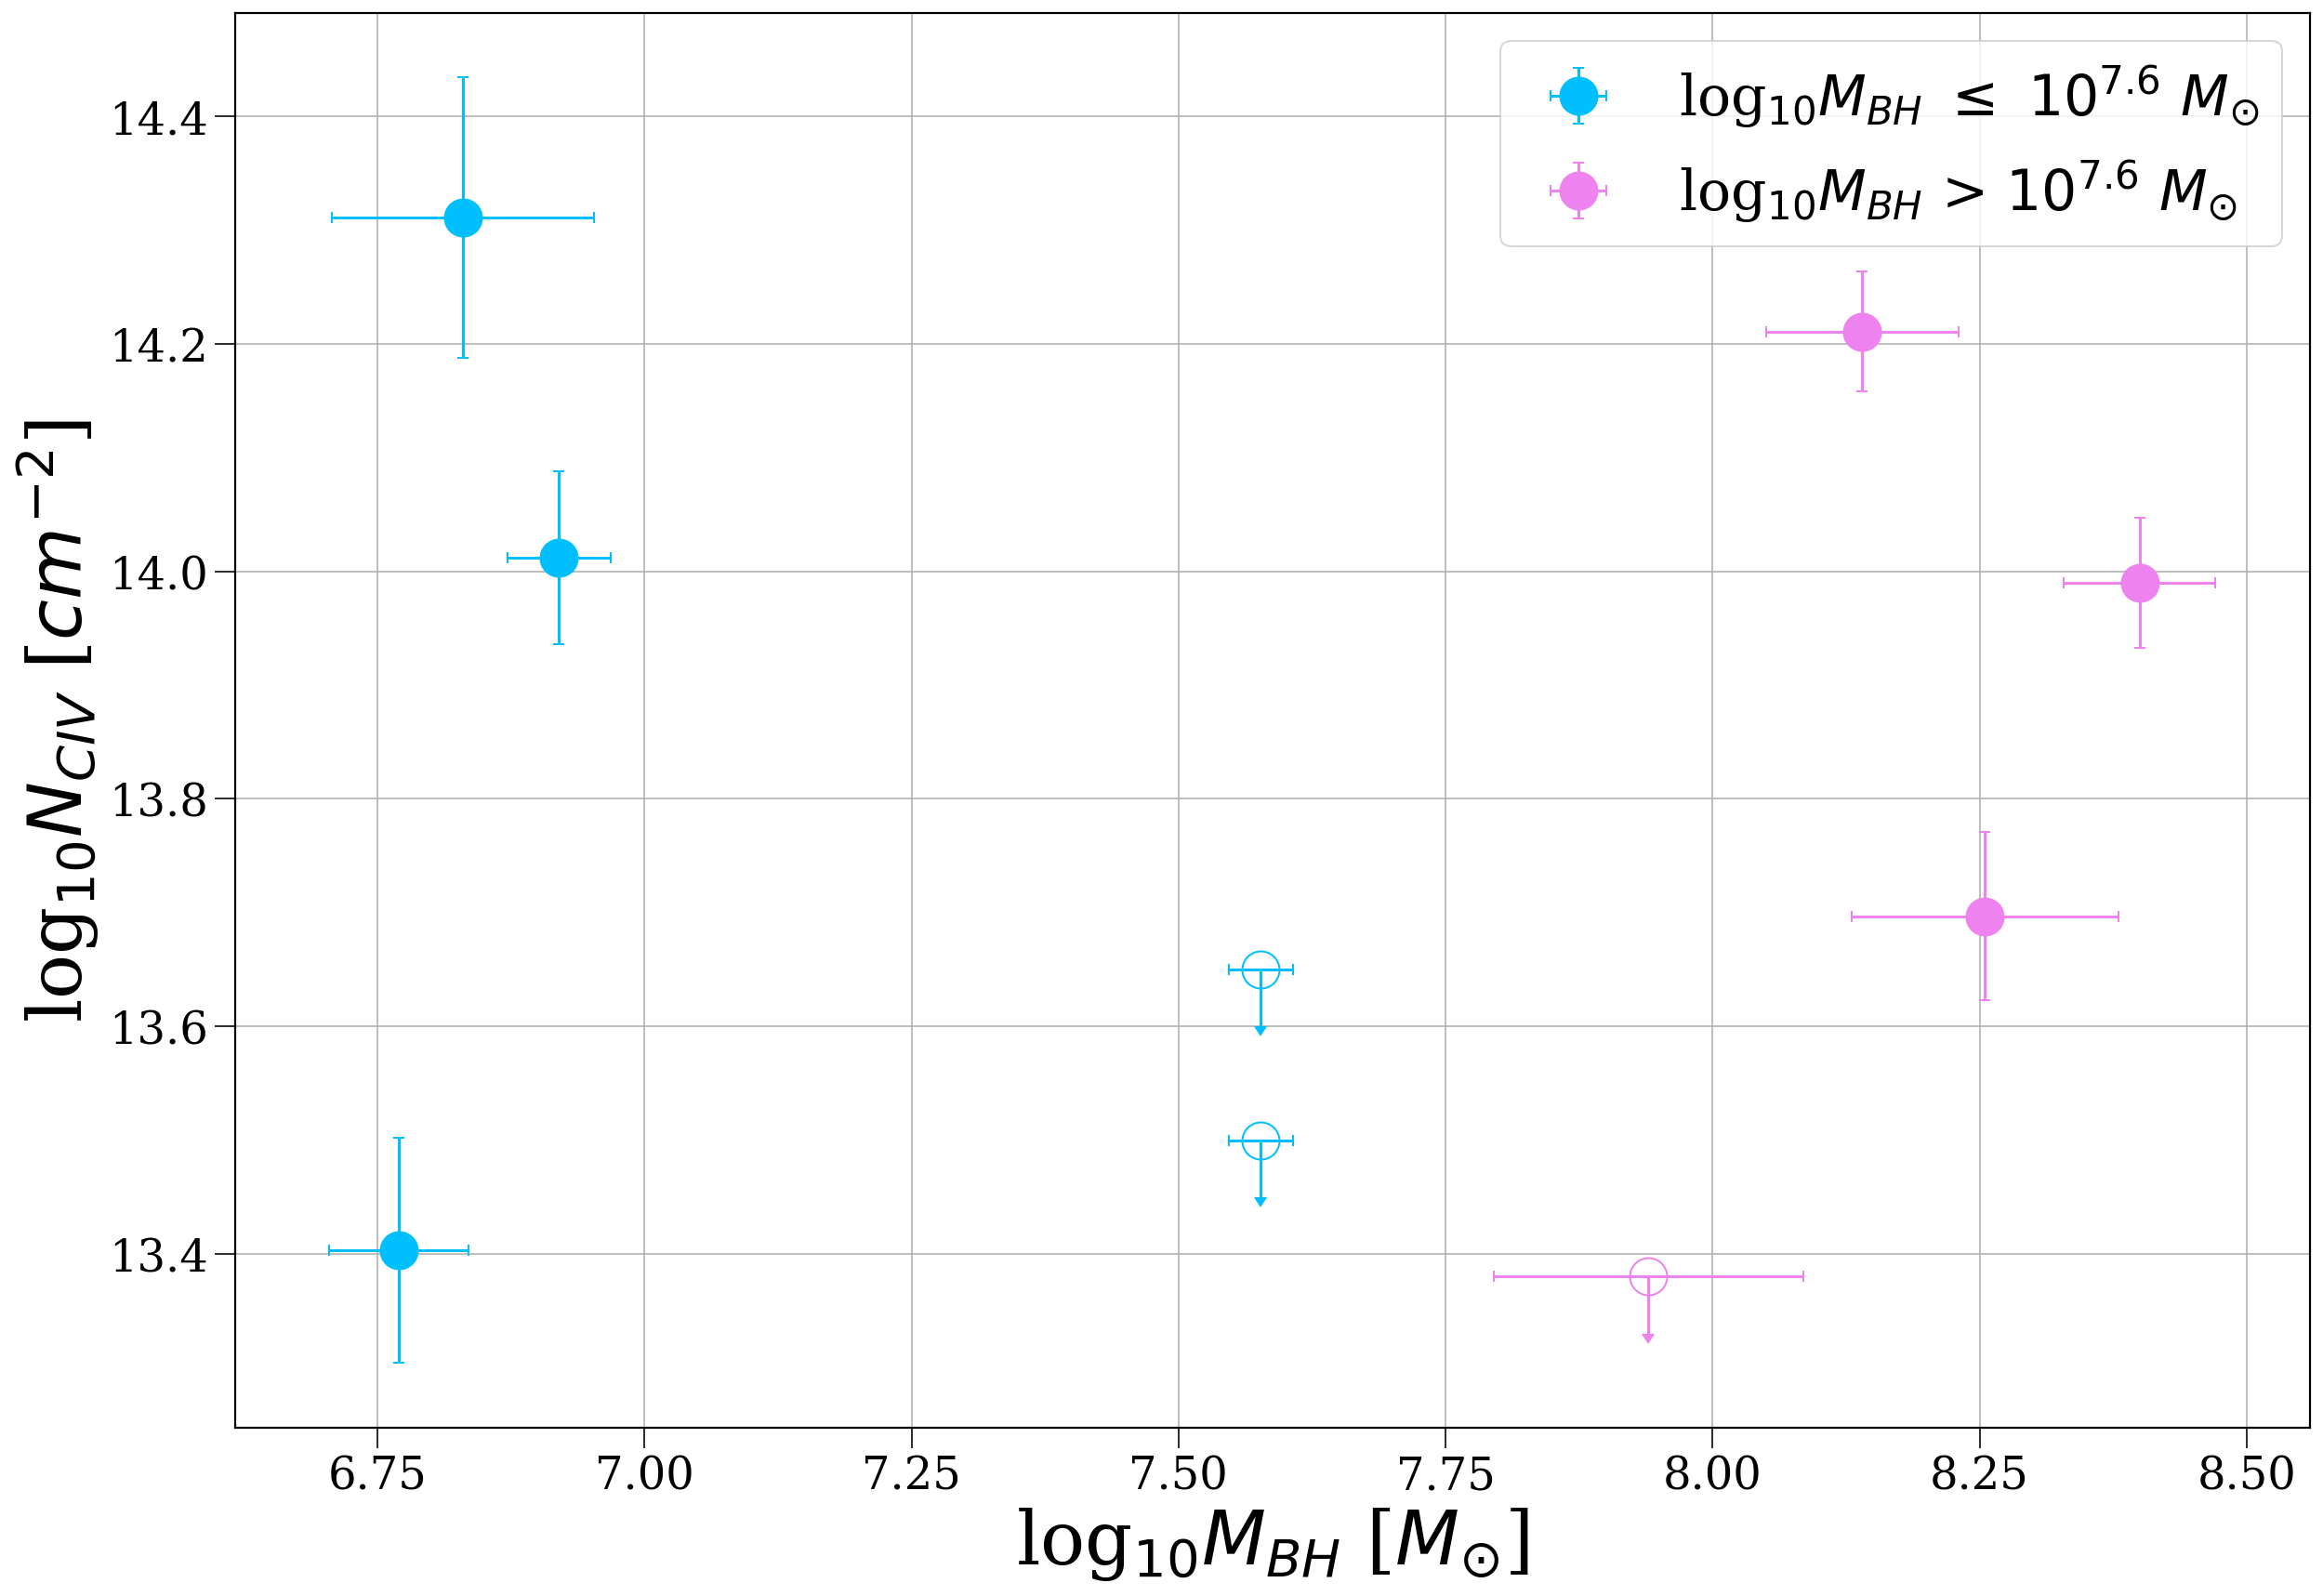

In [47]:
#creating masks to separate into high and low 
low_mask, high_mask = (cosholes_df["MBH"] <= 7.6), (cosholes_df["MBH"] > 7.6)
    

#Plotting NCIV vs MBH    
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["MBH"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], xerr = sum_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["MBH"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], xerr = up_ch['sigMBH'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(fontsize=30)
ax.set_xlabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
plt.grid(True)
plt.show()

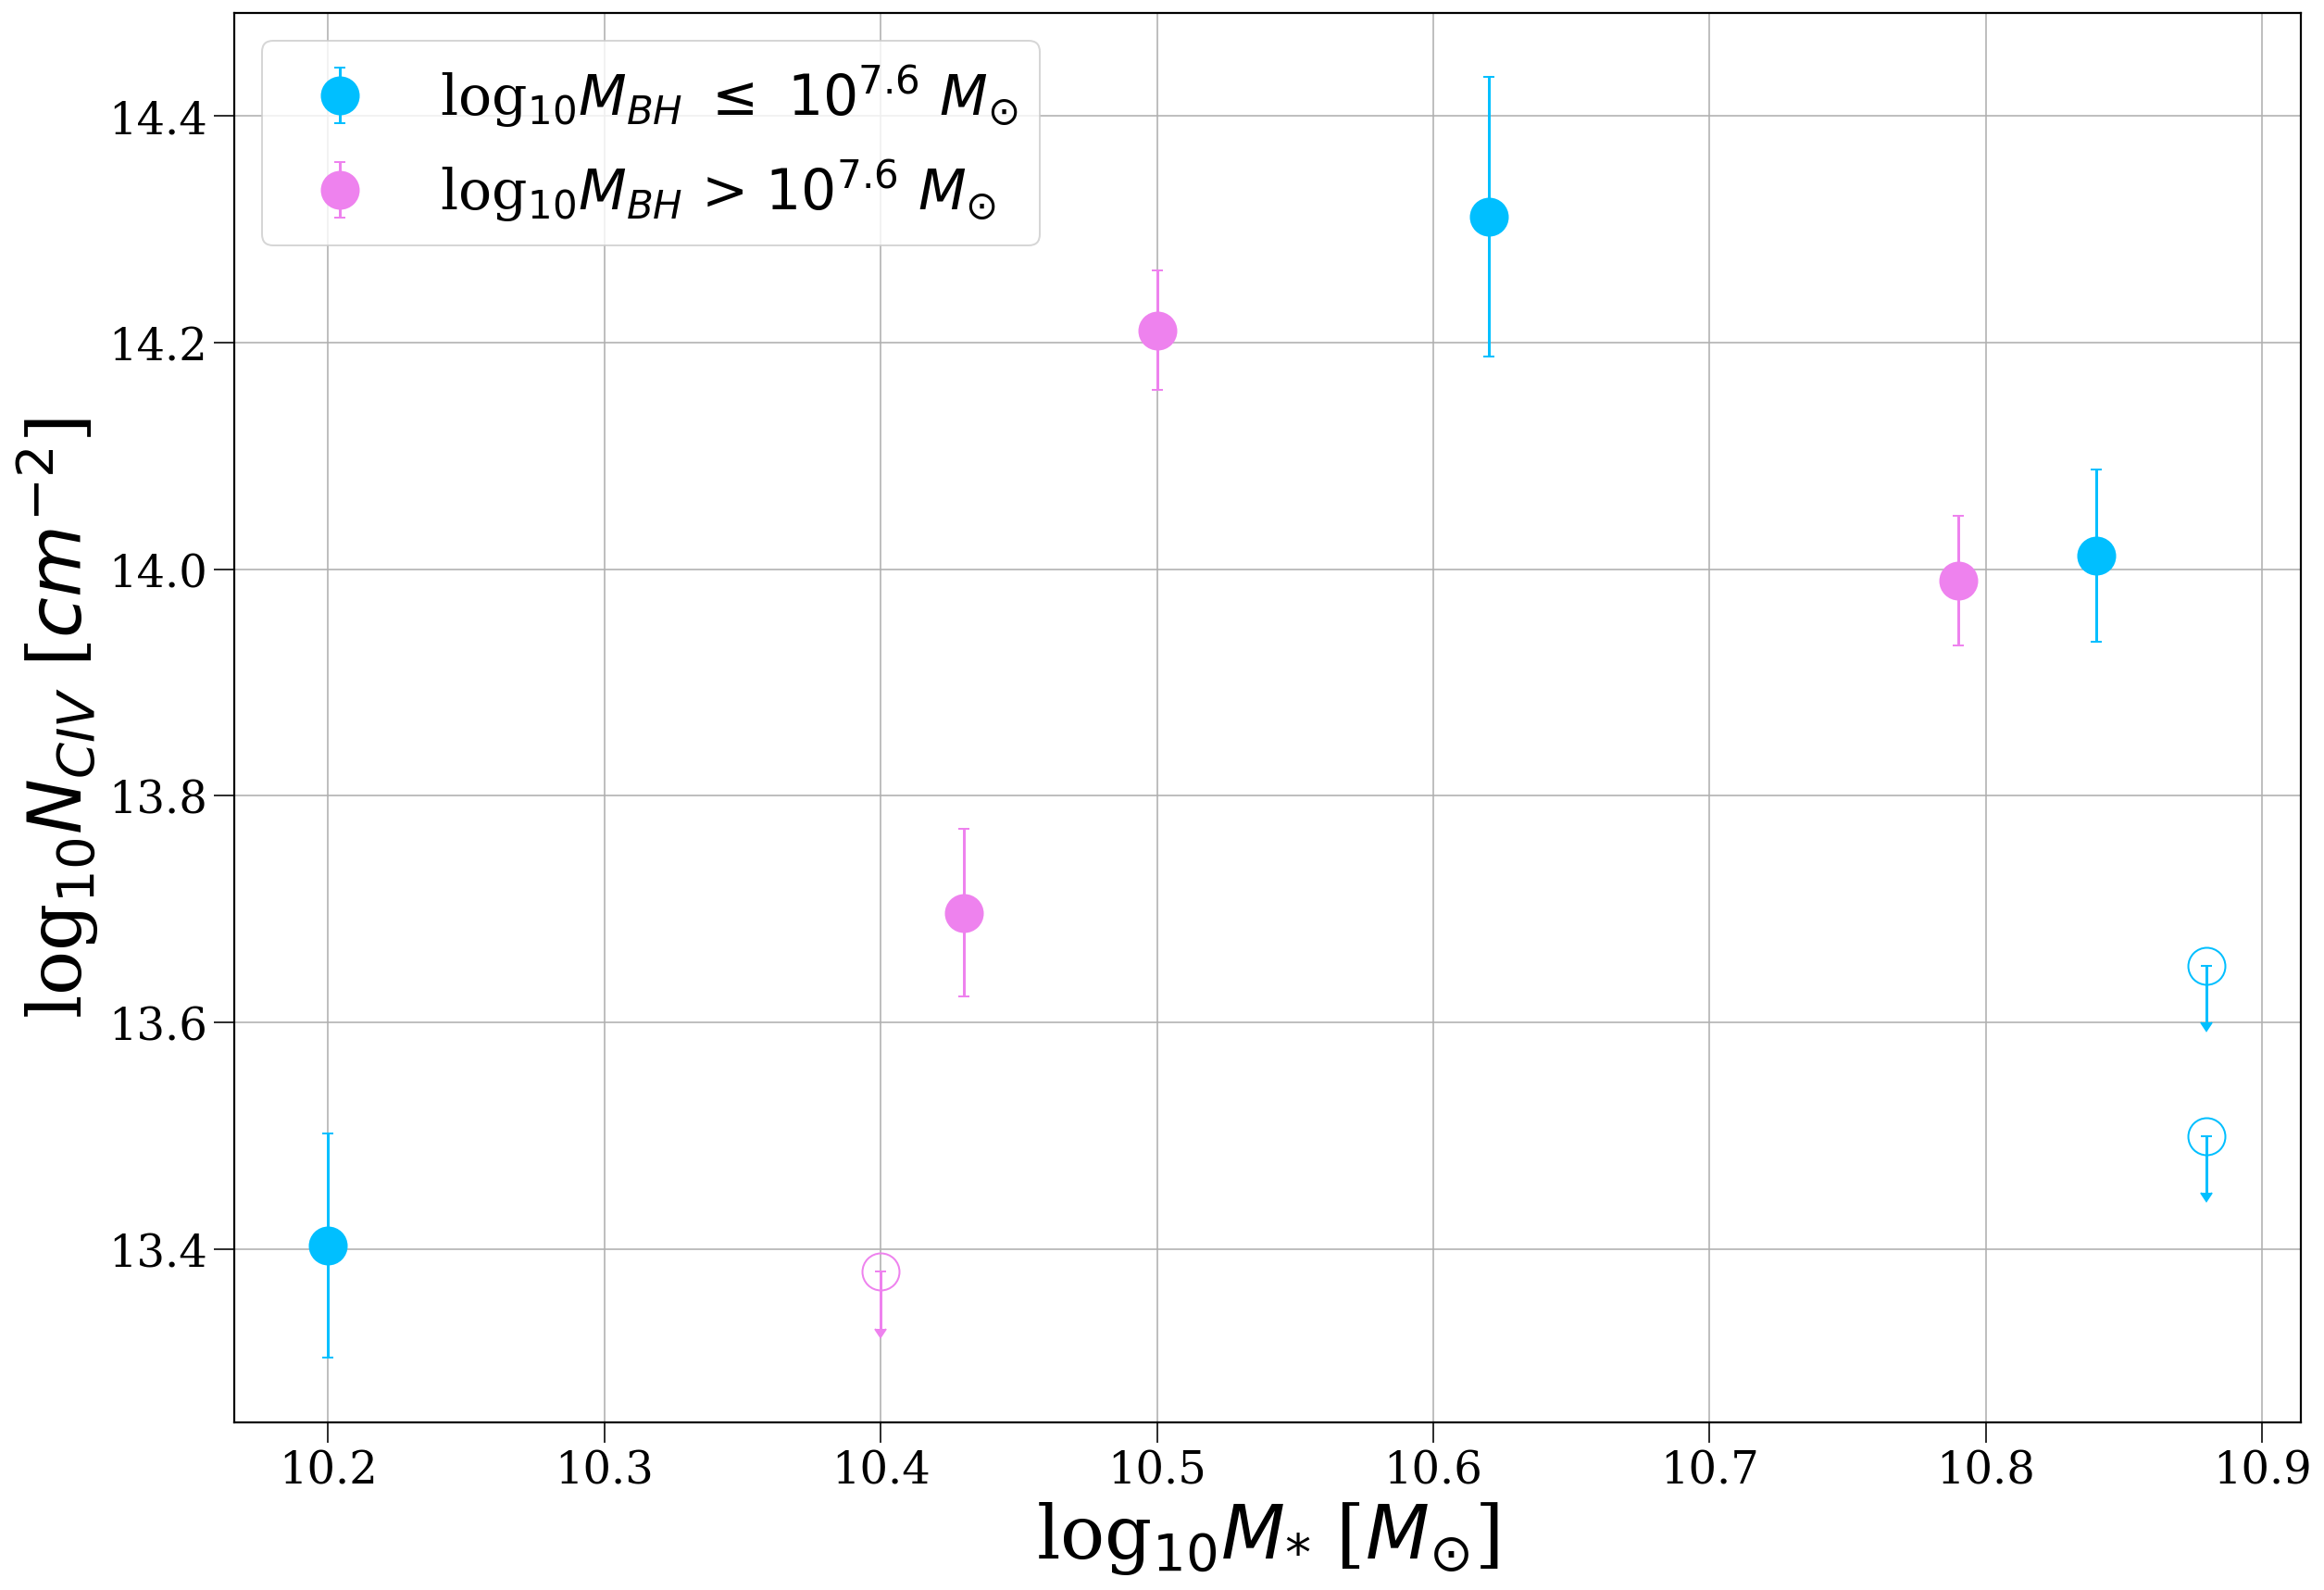

In [51]:
#Plotting NCIV vs M*    
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["M*"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["M*"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=2, fontsize=30)
ax.set_xlabel(r"log$_{10}M_{*}$ [$M_{\odot}$]", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
plt.grid(True)
plt.show()

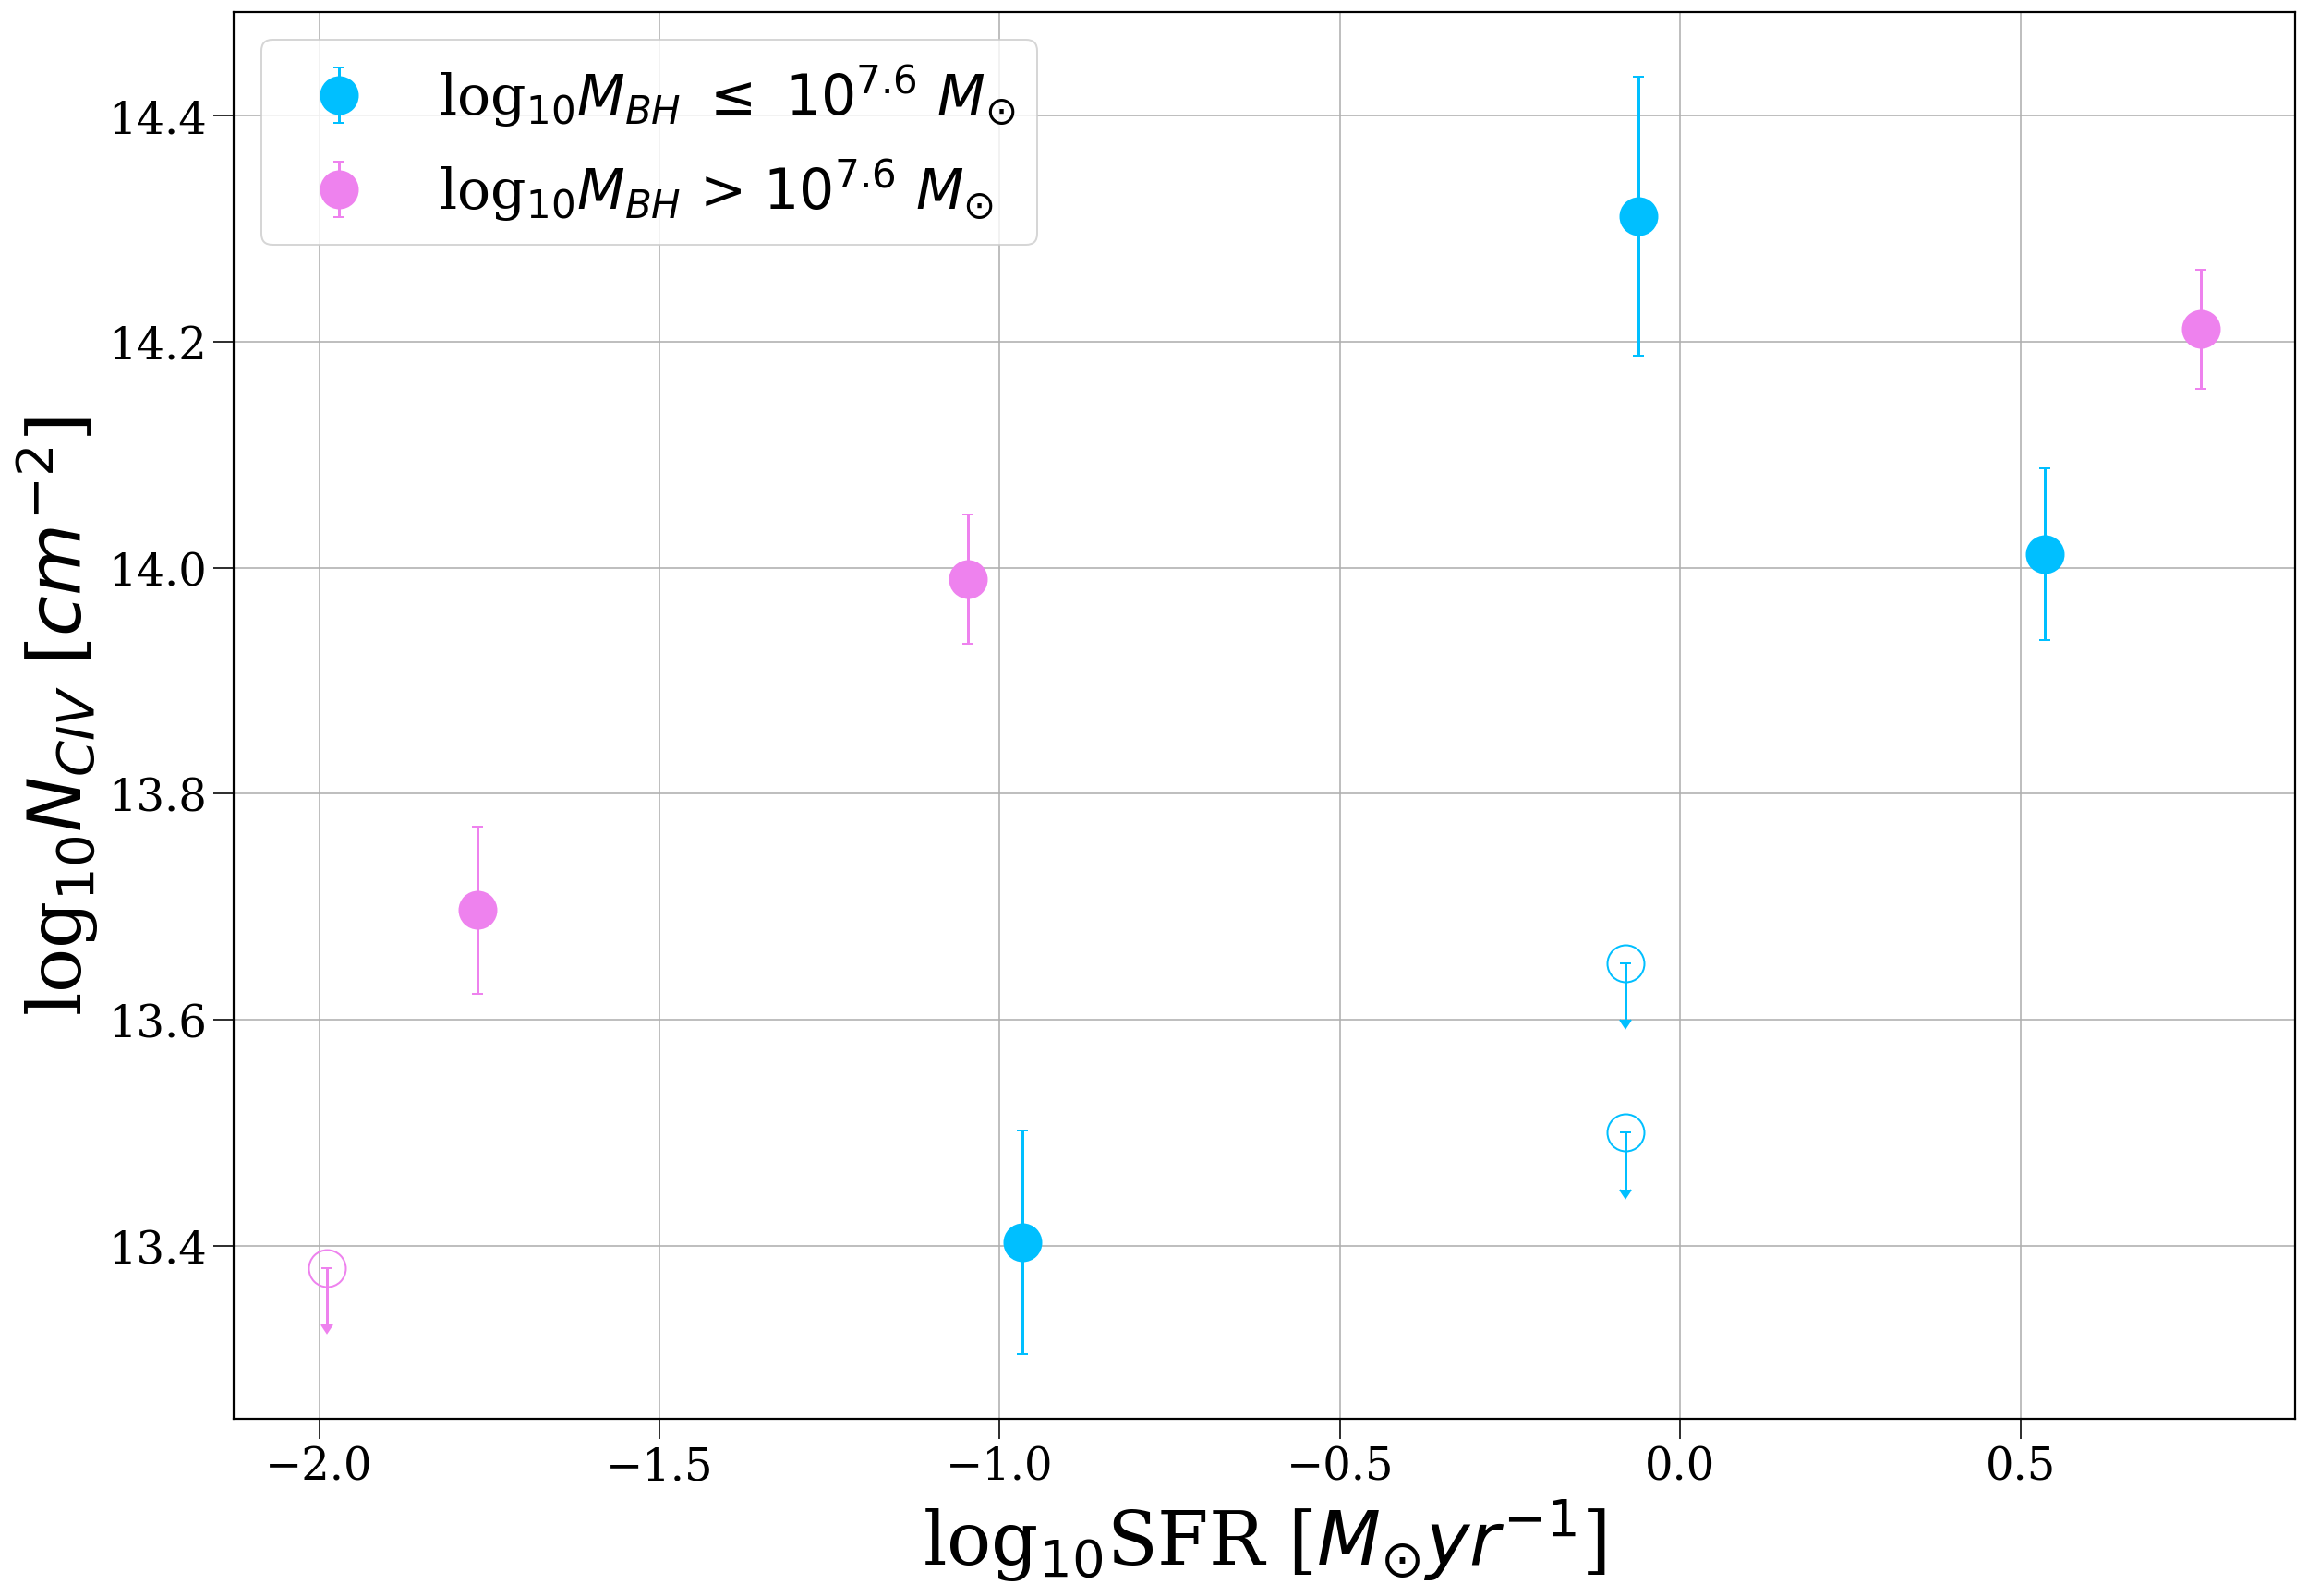

In [52]:
#Plotting NCIV vs SFR    
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["SFR"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["SFR"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=2, fontsize=30)
ax.set_xlabel(r"log$_{10}$SFR [$M_{\odot} yr^{-1}$]", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
plt.grid(True)
plt.show()

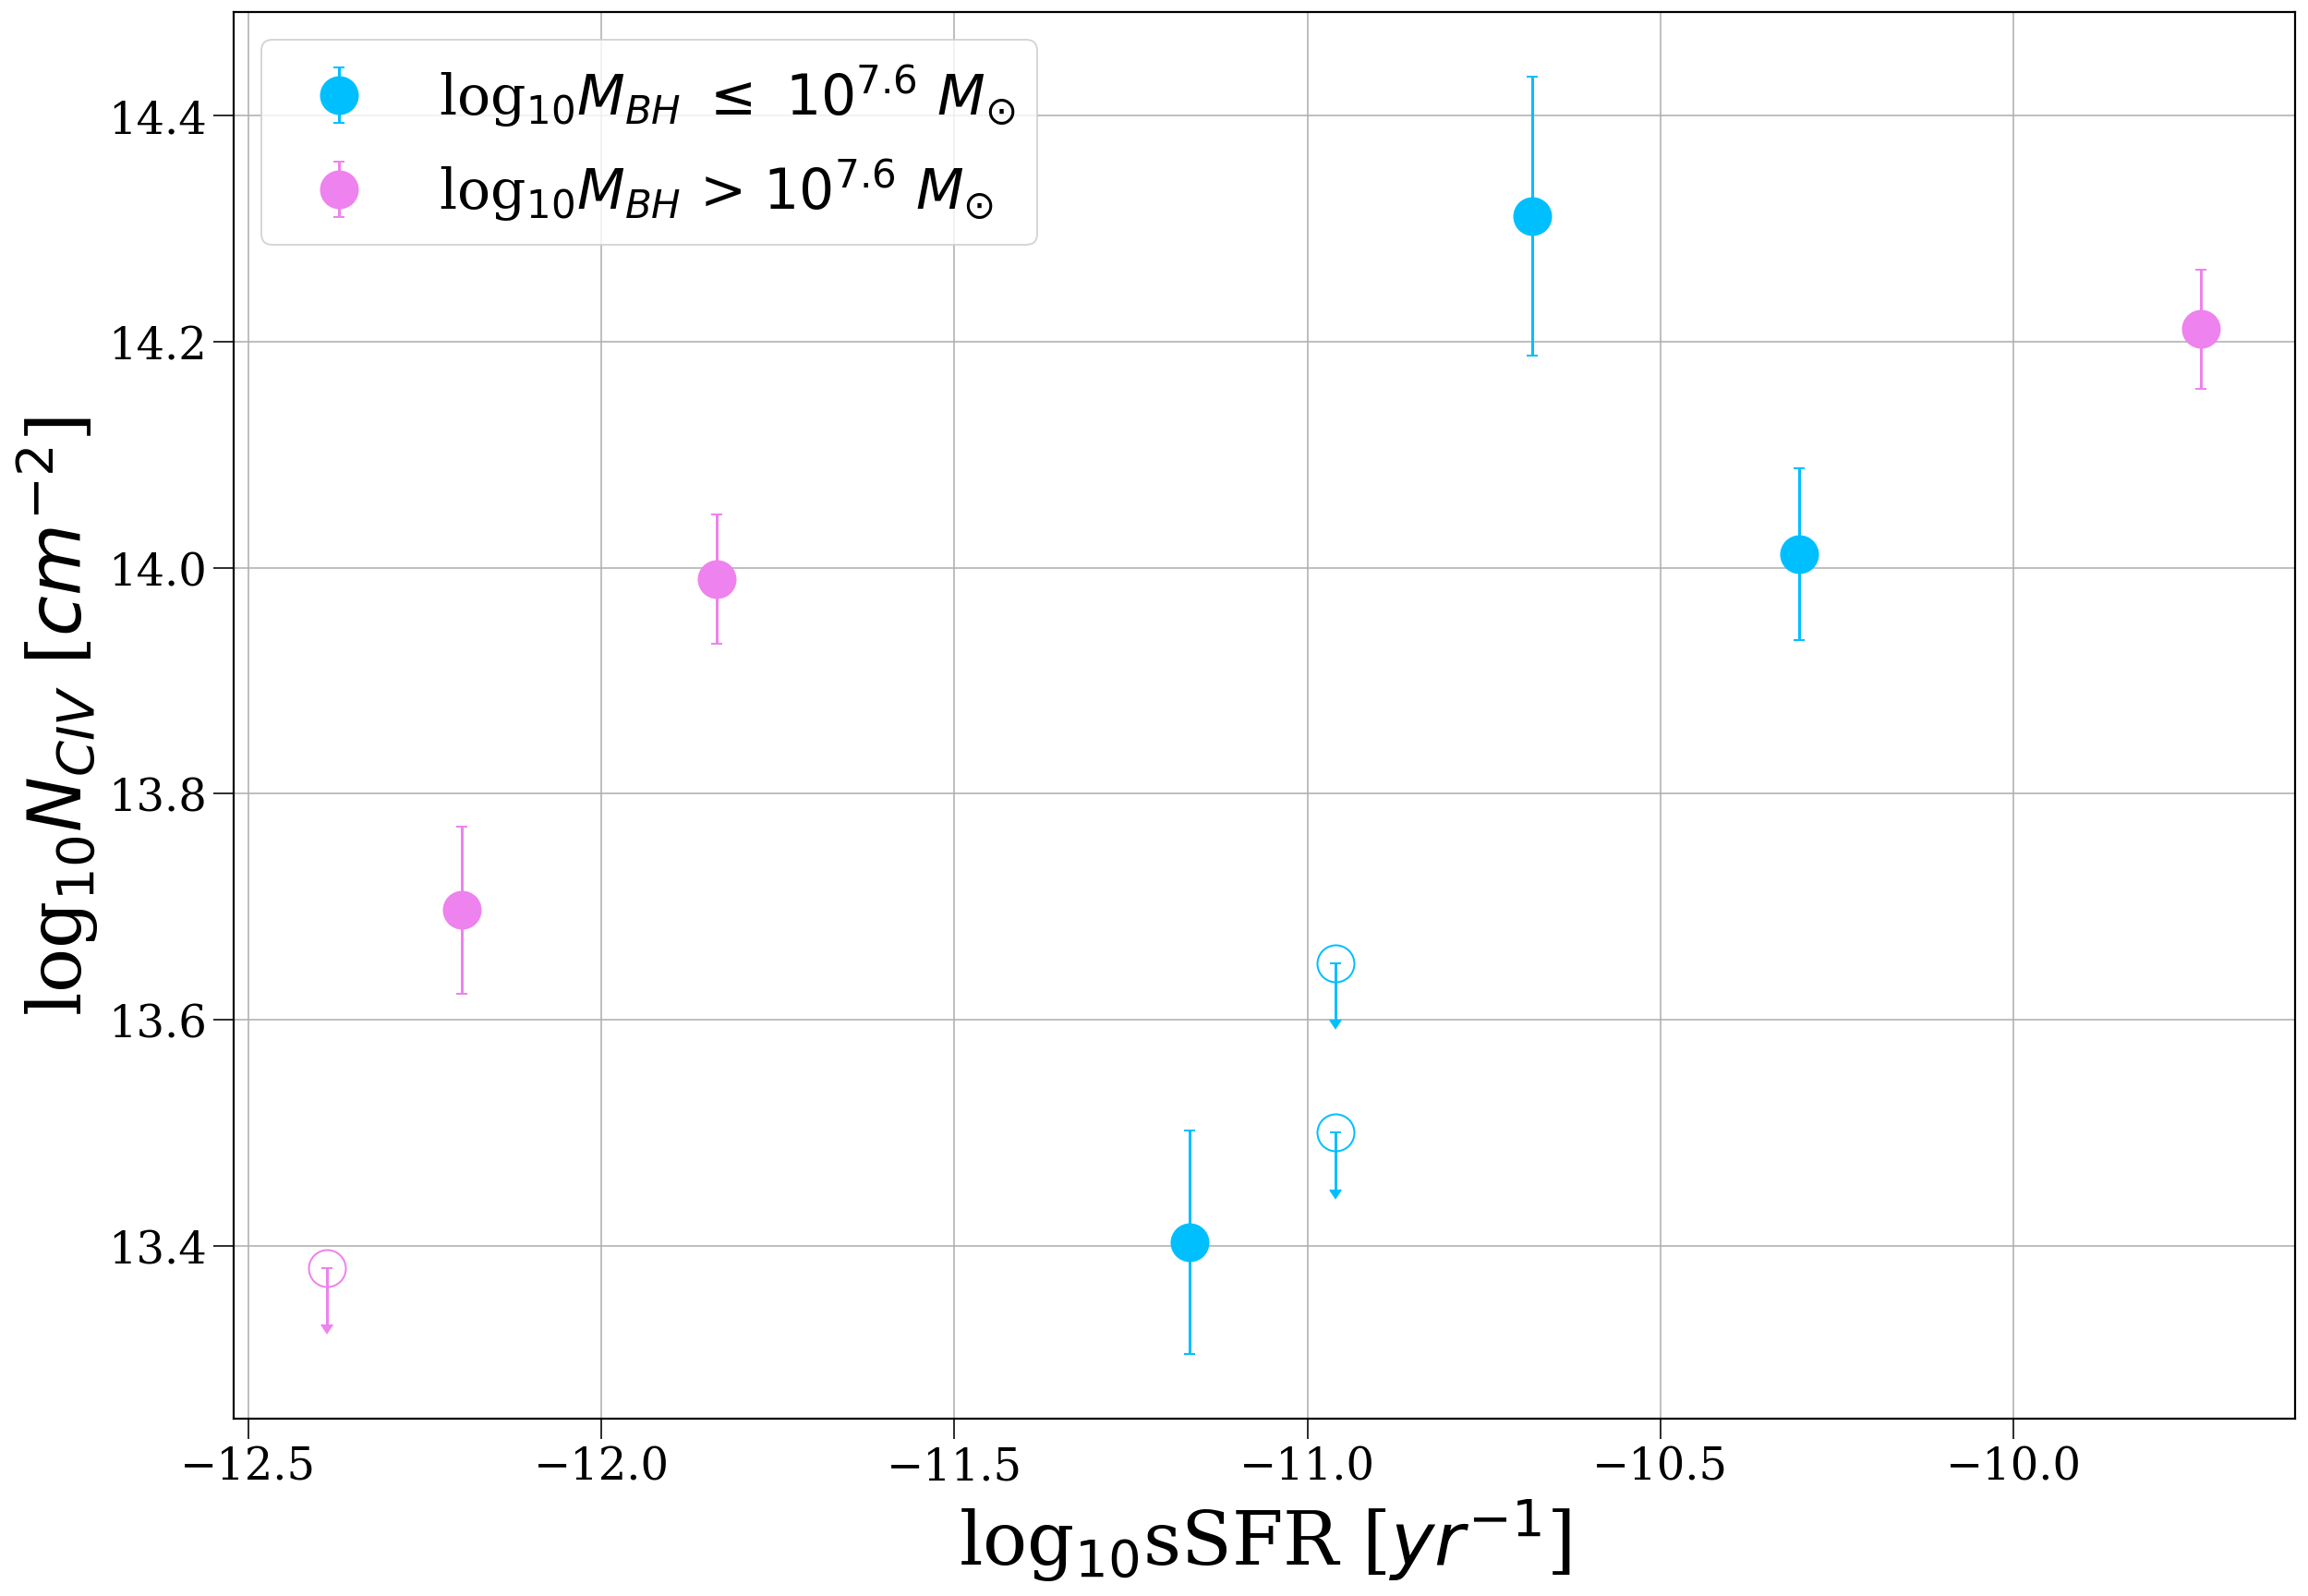

In [54]:
#Plotting NCIV vs sSFR    
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["SFR"][mask] - sum_ch["M*"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["SFR"][mask] -up_ch['M*'][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=2, fontsize=30)
ax.set_xlabel(r"log$_{10}$sSFR [$yr^{-1}$]", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
plt.grid(True)
plt.show()

## Galaxy Kinematics Plot

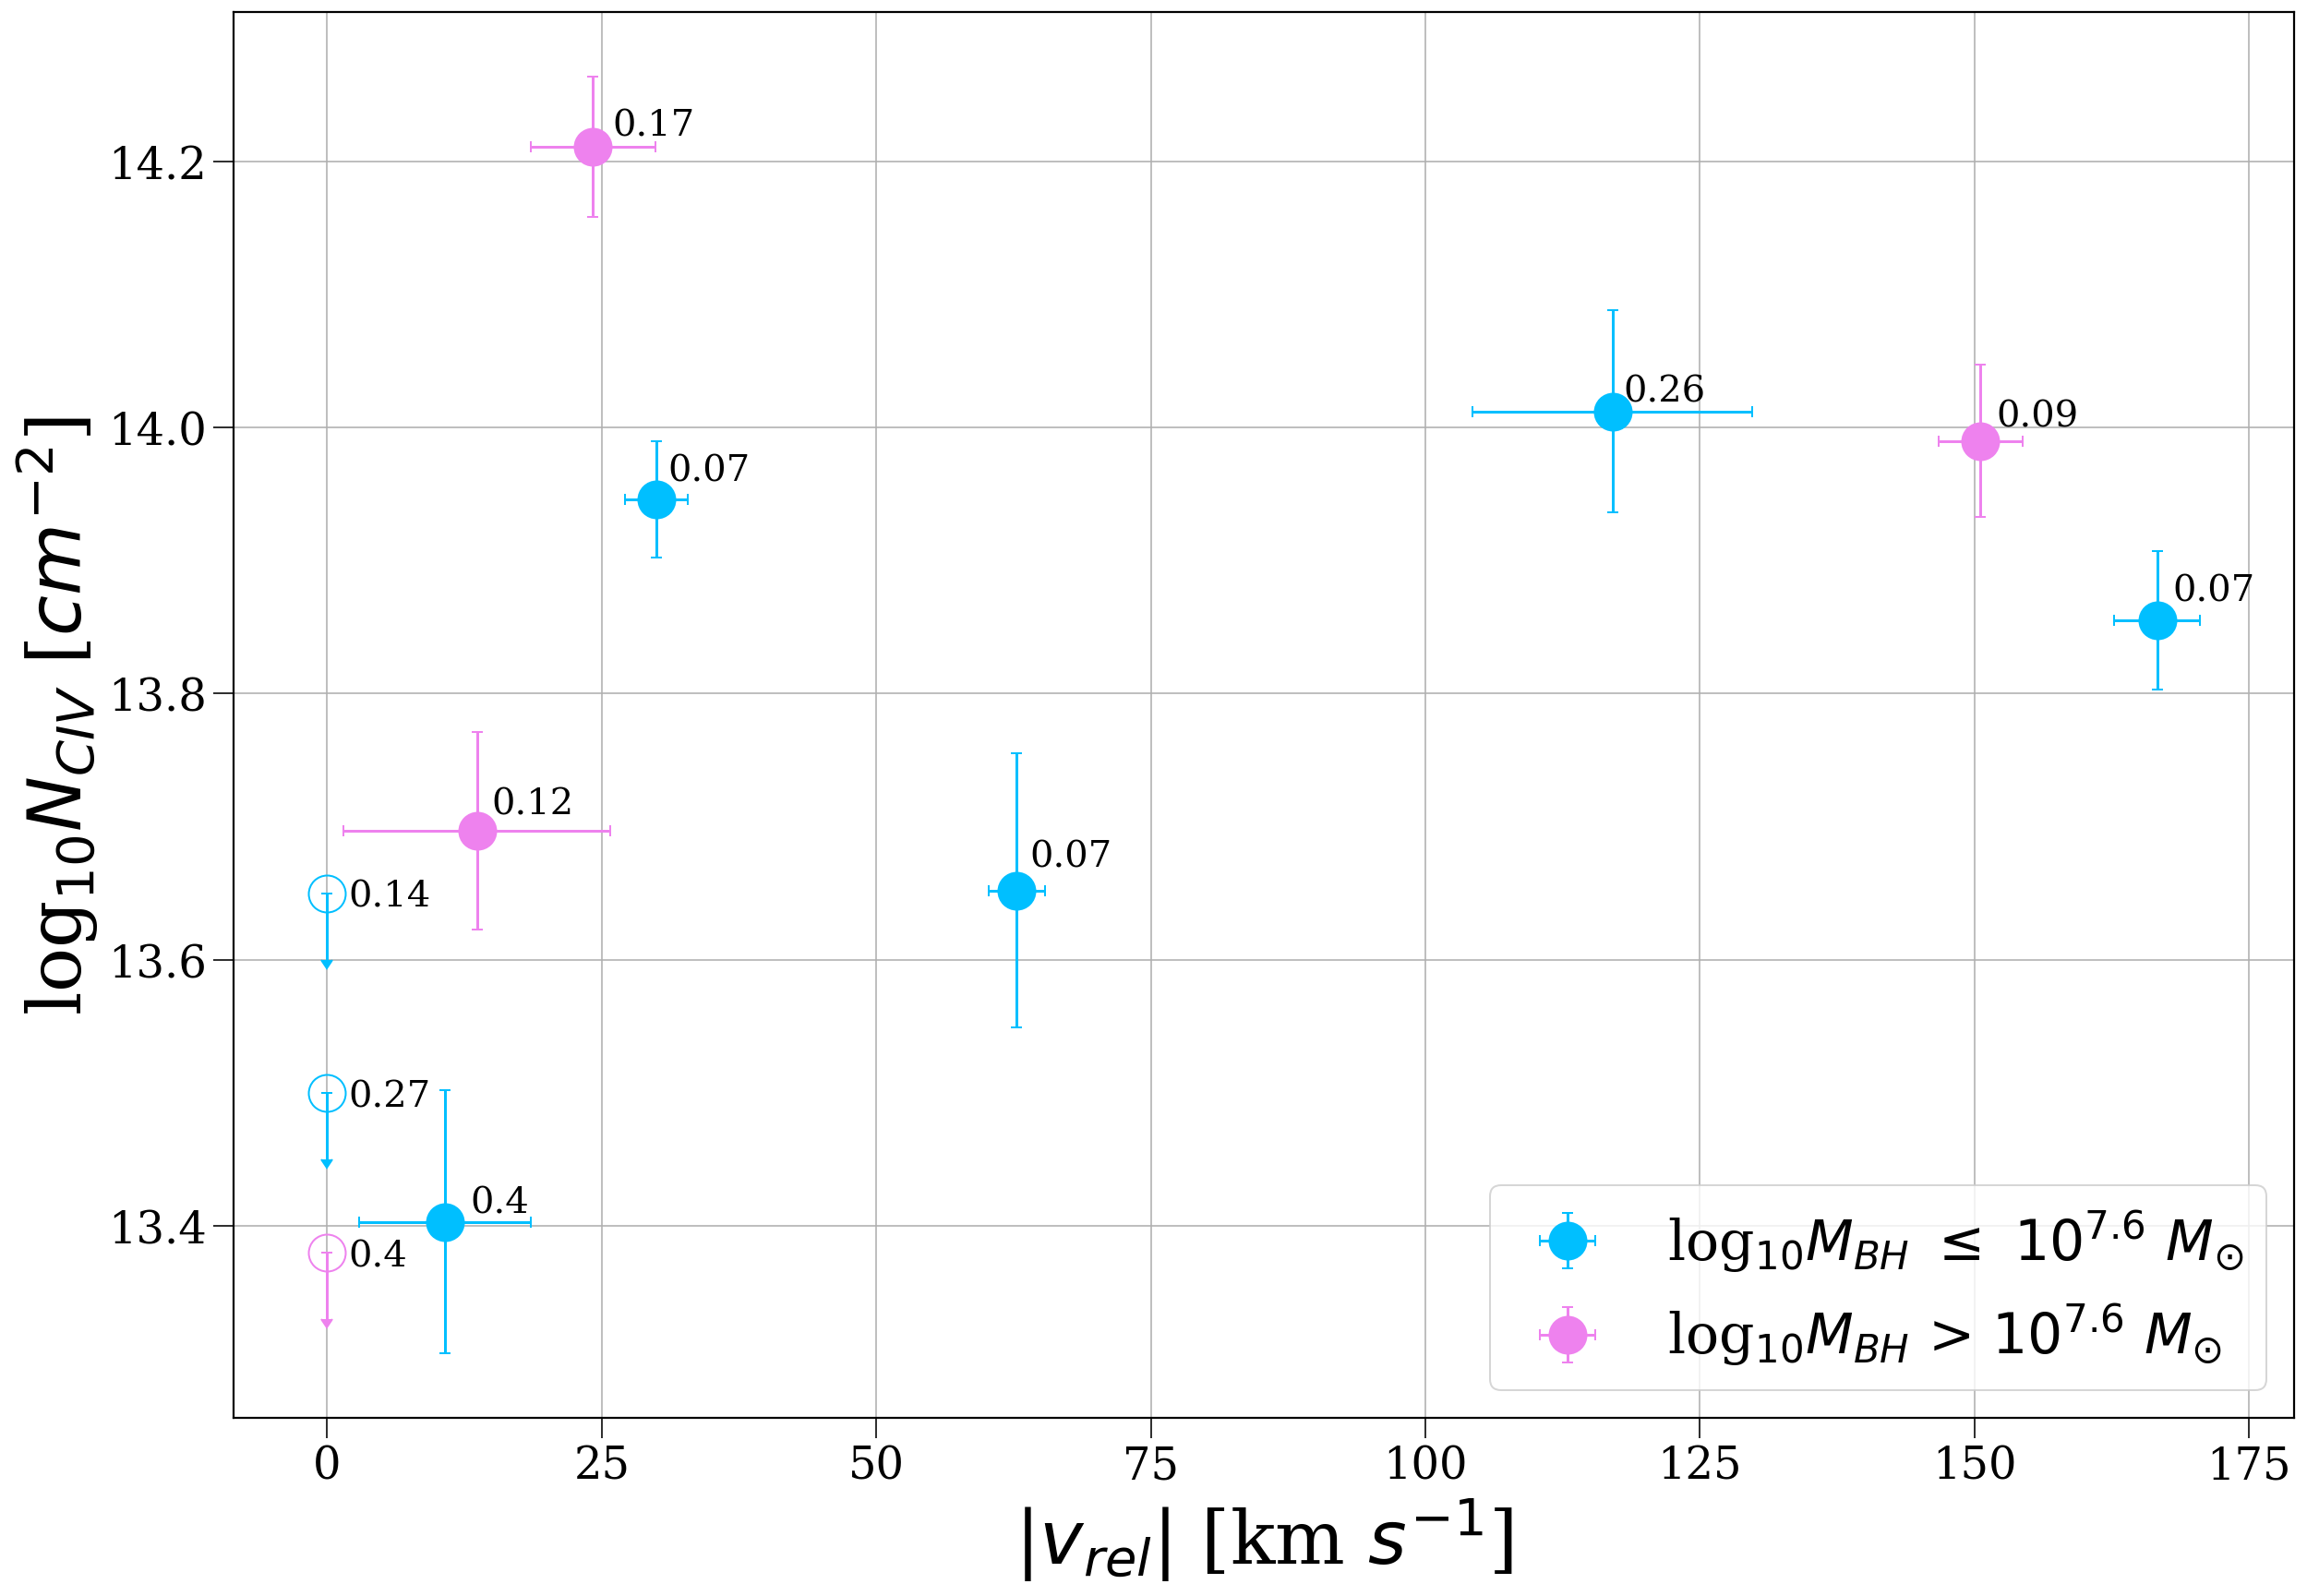

In [91]:
#Plotting NCIV vs |vrel|   
fig, ax = plt.subplots()

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(com_ch["vrel"][mask], com_ch['N'][mask],yerr=com_ch['sigN'][mask],xerr=np.abs(com_ch['sigvel'][mask]), 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["vrel"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][0],2)}", (13, 13.41), fontsize=20) #J1101
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][1],2)}", (15, 13.71), fontsize=20) #J1159
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][5],2)}", (168, 13.87), fontsize=20) #J1249
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][6],2)}", (64, 13.67), fontsize=20) #J1249
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][7],2)}", (31, 13.96), fontsize=20) #J1249
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][8],2)}", (152, 14.001), fontsize=20) #J1051
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][9],2)}", (118, 14.02), fontsize=20) #J1123
plt.annotate(f"{np.round(com_ch['Rproj/Rvir'][10],2)}", (26, 14.22), fontsize=20) #J0246

plt.annotate(f"{np.round(up_ch['Rproj/Rvir'][2],2)}", (1.9, 13.64), fontsize=20) #J1220
plt.annotate(f"{np.round(up_ch['Rproj/Rvir'][3],2)}", (1.9, 13.49), fontsize=20) #J1222
plt.annotate(f"{np.round(up_ch['Rproj/Rvir'][11],2)}", (1.9, 13.37), fontsize=20) #J1235

ax.legend(loc=4, fontsize=30)
ax.set_xlabel(r"|$v_{rel}$| [km $s^{-1}$]", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
plt.grid(True)
plt.show()

## Comparing COS-Holes to Simulations 

### EAGLE

In [94]:
df_rr_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_96_2bins.MS102_109.5.6_7.6.dat",sep="\s+")
#df_rr_low

<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/1967624354.py:1: DeprecationWarning: invalid escape sequence \s
  df_rr_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_96_2bins.MS102_109.5.6_7.6.dat",sep="\s+")


In [95]:
df_rr_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_96_2bins.MS102_109.7.6_9.6.dat",sep="\s+")
#df_rr_high

<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/2383971751.py:1: DeprecationWarning: invalid escape sequence \s
  df_rr_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_96_2bins.MS102_109.7.6_9.6.dat",sep="\s+")


In [96]:
df_r_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH56_96_2bins.MS102_109.5.6_7.6.dat",sep="\s+")
#df_r_low

<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/3166990657.py:1: DeprecationWarning: invalid escape sequence \s
  df_r_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH56_96_2bins.MS102_109.5.6_7.6.dat",sep="\s+")


In [97]:
df_r_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH56_96_2bins.MS102_109.7.6_9.6.dat",sep="\s+")
#df_r_high

<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/581614573.py:1: DeprecationWarning: invalid escape sequence \s
  df_r_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH56_96_2bins.MS102_109.7.6_9.6.dat",sep="\s+")


<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/1847294150.py:10: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_r_high['#R(kpc)'], df_r_high['median'], color = 'violet', lw = 3, label = 'EAGLE: log$M_{BH}$ > $10^{7.6}$ $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/1847294150.py:12: DeprecationWarning: invalid escape sequence \l
  plt.plot(df_r_low['#R(kpc)'], df_r_low['median'], color = 'deepskyblue', lw = 3, label = 'EAGLE: log$M_{BH}$ $\leq$ $

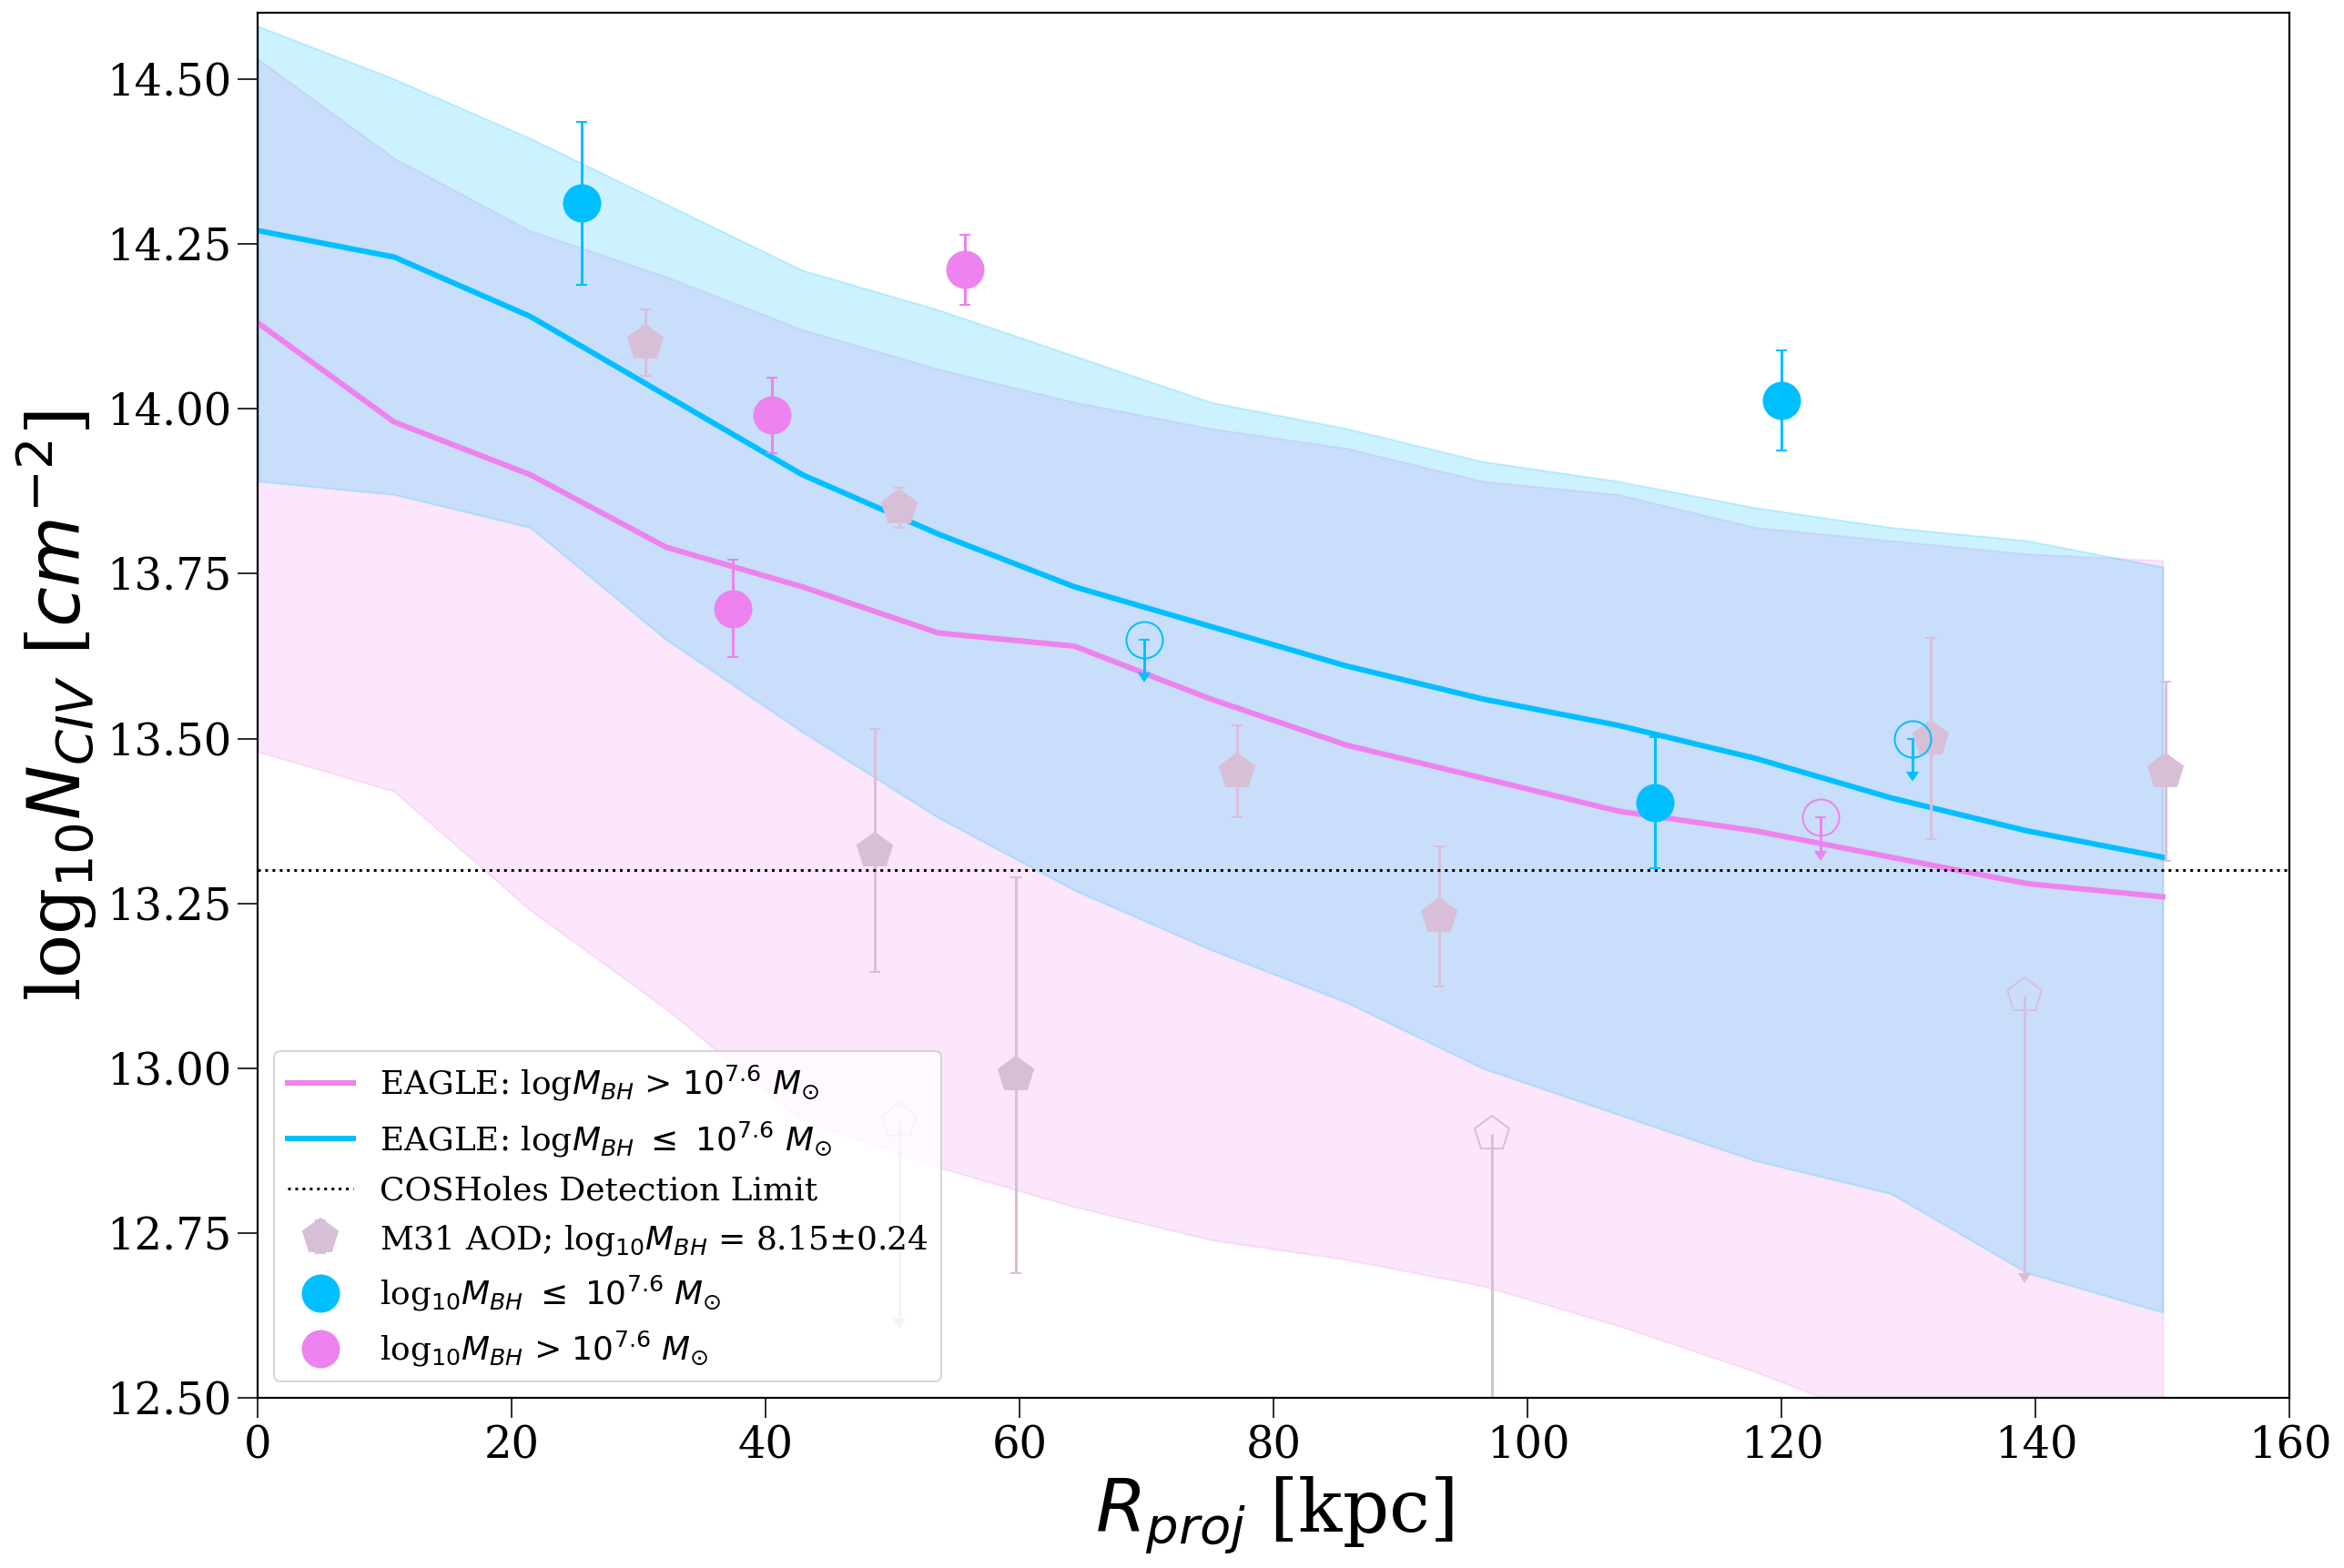

In [101]:
#Plotting NCIV vs Rproj 
    
fig, ax = plt.subplots()

########################################################

#EAGLE Simulational Data

plt.fill_between(df_r_high['#R(kpc)'], df_r_high['16percentile'], df_r_high['84percentile'], alpha = 0.2, color = 'violet')
plt.plot(df_r_high['#R(kpc)'], df_r_high['median'], color = 'violet', lw = 3, label = 'EAGLE: log$M_{BH}$ > $10^{7.6}$ $M_{\odot}$')
plt.fill_between(df_r_low['#R(kpc)'], df_r_low['16percentile'], df_r_low['84percentile'], alpha = 0.2, color = 'deepskyblue')
plt.plot(df_r_low['#R(kpc)'], df_r_low['median'], color = 'deepskyblue', lw = 3, label = 'EAGLE: log$M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$')

   
########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 , used lightgrey before 

##### M31 Detections (Sums) 
plt.errorbar (amiga_2_det_sum['Rad'], amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = 'thistle', 
              marker="p", markersize=20, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24', ls='none')

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_2_up_sum['Rad'], amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = 'thistle', 
              marker="p",mfc='none',markersize=20, ls='none')

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=3, fontsize=18)
ax.set_xlabel(r"$R_{proj}$ [kpc]", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
ax.set_ylim(12.5, 14.6)
ax.set_xlim(0, 160)
plt.show()

<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:21: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:21: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \o
<>:12: DeprecationWarning: invalid escape sequence \l
<>:21: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/1380695841.py:10: DeprecationWarning: invalid escape sequence \o
  plt.plot(df_rr_high['#R/R200'], df_rr_high['median'], color = 'violet', lw = 3, label = 'EAGLE: log$M_{BH}$ > $10^{7.6}$ $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/1380695841.py:12: DeprecationWarning: invalid escape sequence \l
  plt.plot(df_rr_low['#R/R200'], df_rr_low['median'], color = 'deepskyblue', lw = 3, label = 'EAGLE: log$M_{BH}$ $\le

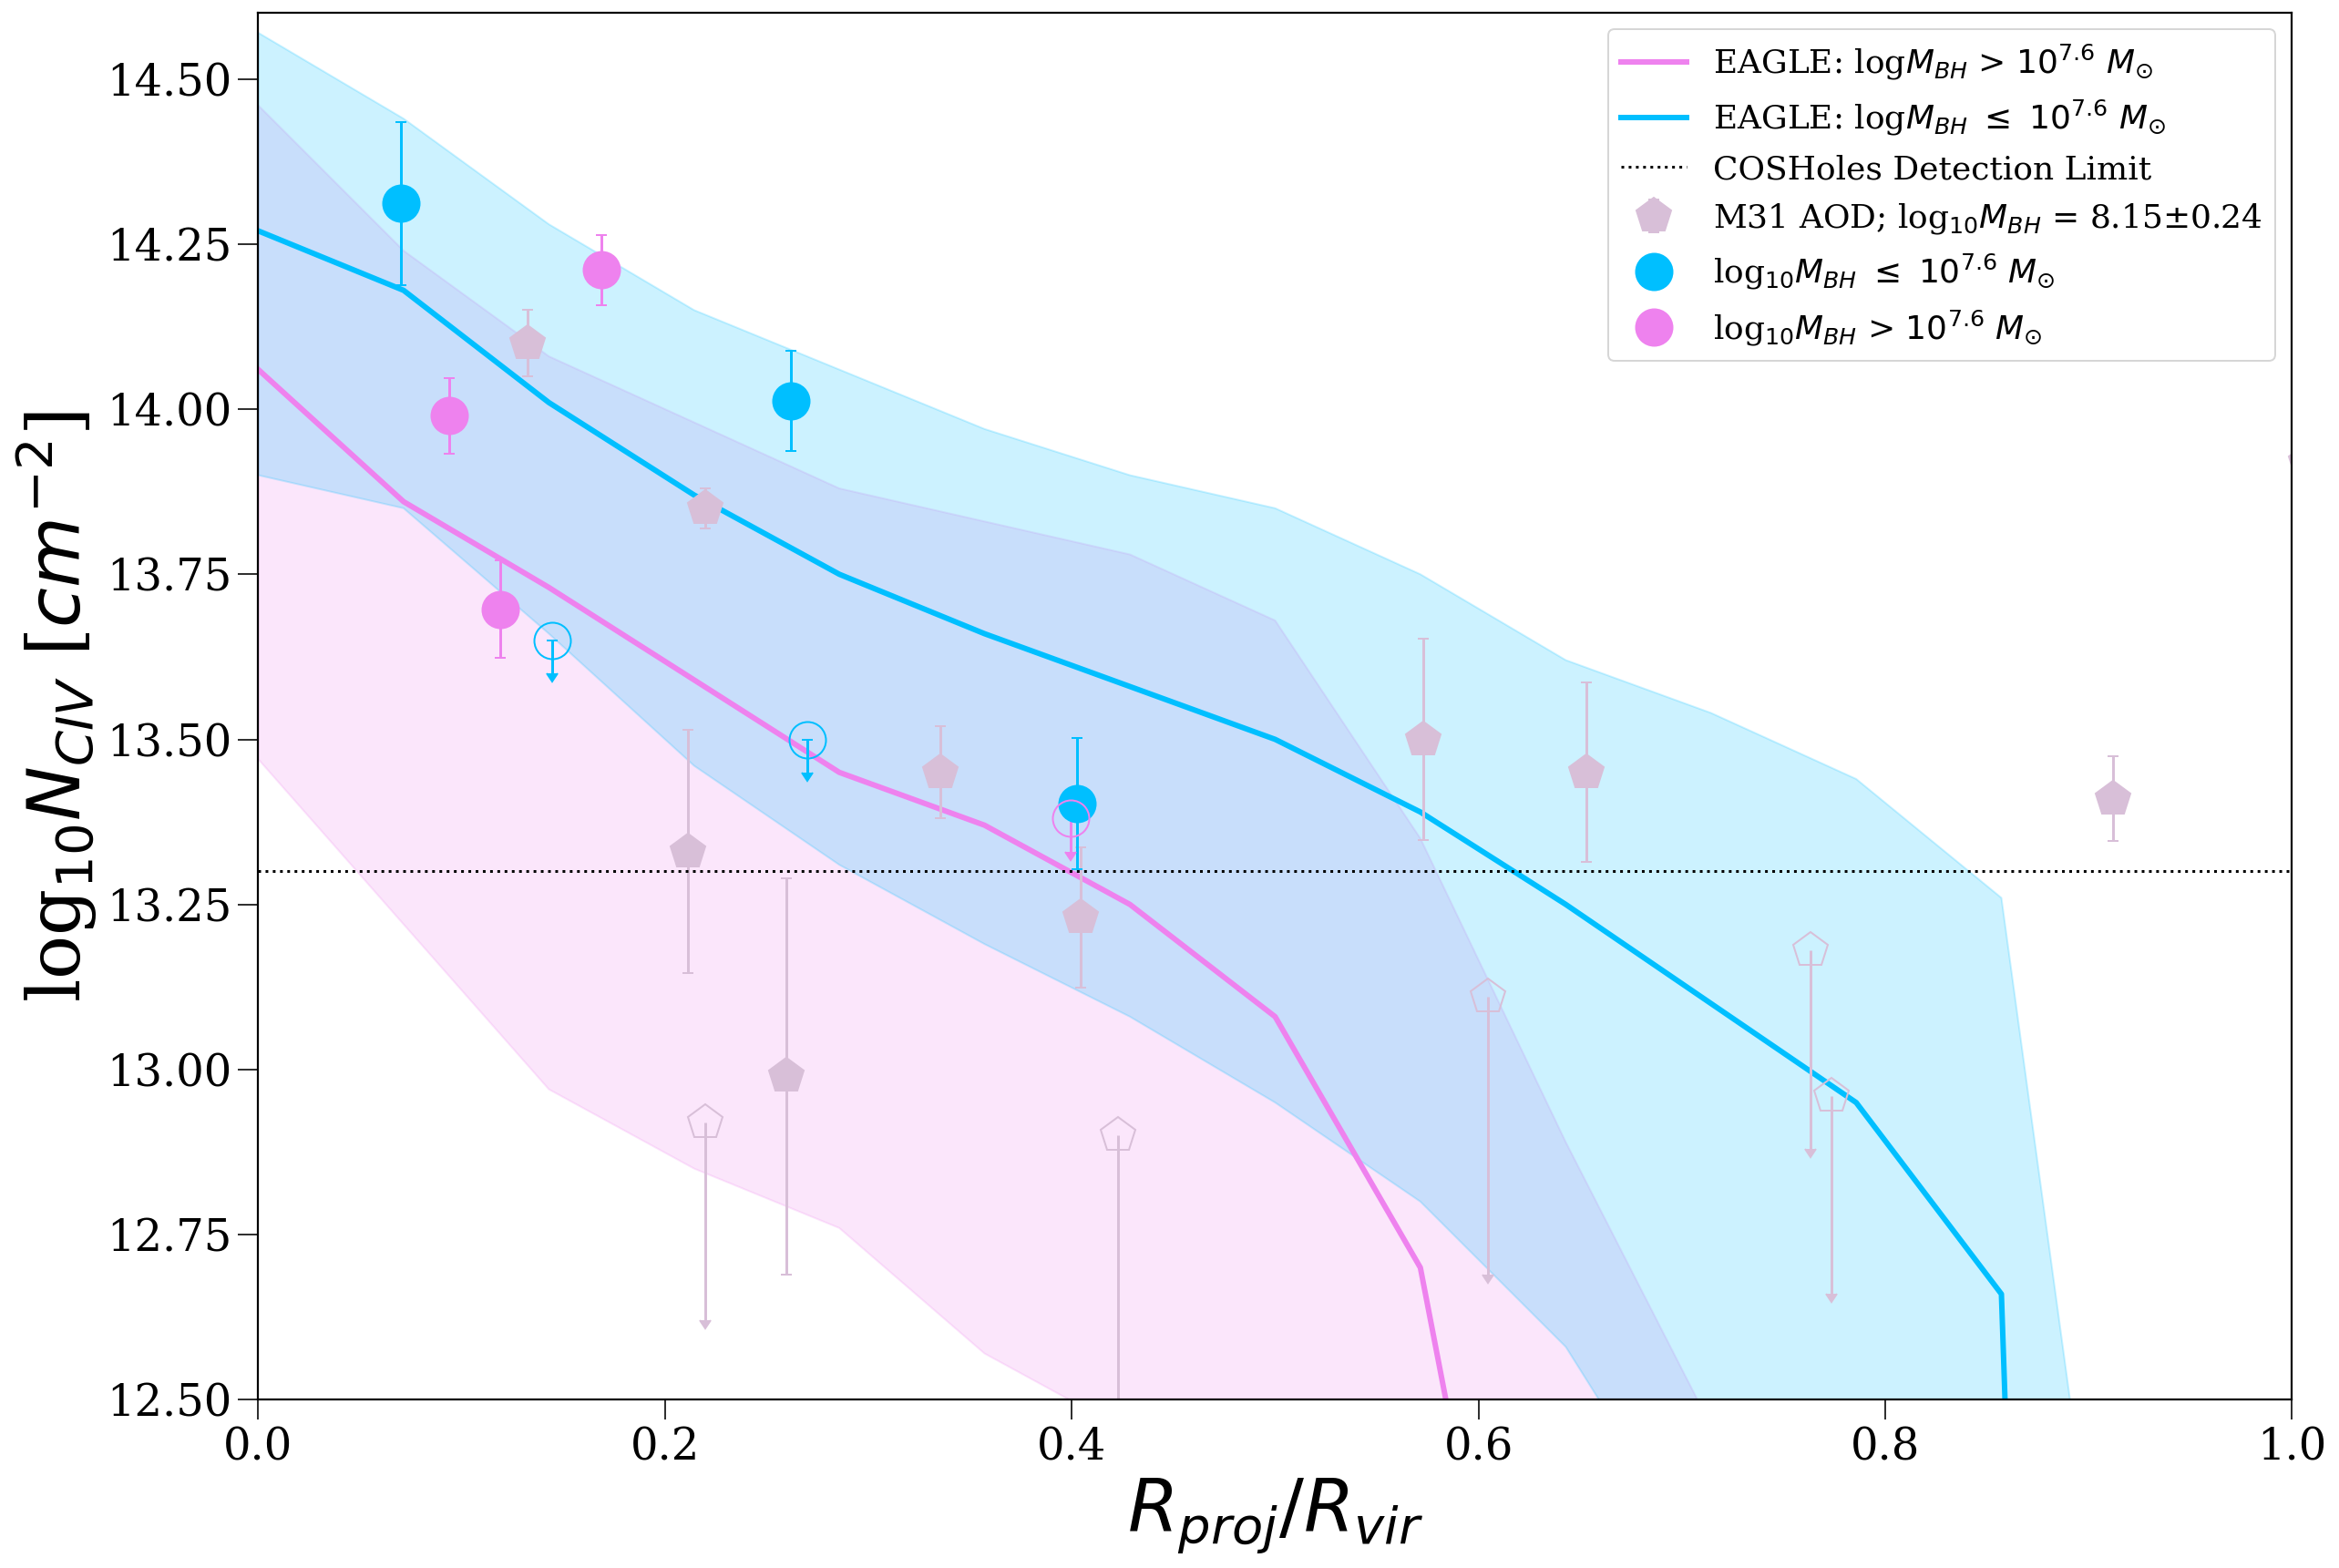

In [112]:
#Plotting NCIV vs Rproj/Rvir

fig, ax = plt.subplots()

########################################################

#EAGLE

plt.fill_between(df_rr_high['#R/R200'], df_rr_high['16percentile'], df_rr_high['84percentile'], alpha = 0.2, color = 'violet')
plt.plot(df_rr_high['#R/R200'], df_rr_high['median'], color = 'violet', lw = 3, label = 'EAGLE: log$M_{BH}$ > $10^{7.6}$ $M_{\odot}$')
plt.fill_between(df_rr_low['#R/R200'], df_rr_low['16percentile'], df_rr_low['84percentile'], alpha = 0.2, color = 'deepskyblue')
plt.plot(df_rr_low['#R/R200'], df_rr_low['median'], color = 'deepskyblue', lw = 3, label = 'EAGLE: log$M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = 'thistle', 
              marker="p", markersize=20, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24', ls='none')

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = 'thistle', 
              marker="p",mfc='none',markersize=20, ls='none')

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=1, fontsize=18)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
ax.set_ylim(12.5, 14.6)
ax.set_xlim(0, 1)
plt.show()

#### Calculating Simga Values for EAGLE

In [139]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the sum values 
eagle_sum = {'QSO': ['J1101', 'J1159', 'J1249', 'J1051', 'J1123', 'J0246'],
             'R': [df_r_low['#R(kpc)'][10], df_r_high['#R(kpc)'][3], df_r_low['#R(kpc)'][2], df_r_high['#R(kpc)'][4],
               df_r_low['#R(kpc)'][11], df_r_high['#R(kpc)'][5]],
         'RR': [df_rr_low['#R/R200'][6], df_rr_high['#R/R200'][1], df_rr_low['#R/R200'][1], df_rr_high['#R/R200'][1],
                df_rr_low['#R/R200'][4], df_rr_high['#R/R200'][2]],
        'medianCIV': [df_r_low['median'][10], df_r_high['median'][3], df_r_low['median'][2], df_r_high['median'][4], 
                     df_r_high['median'][11], df_r_high['median'][5]], 
            'medianCIVRR': [df_rr_low['median'][6], df_rr_low['median'][1], df_rr_low['median'][1], df_rr_low['median'][1], 
                           df_rr_low['median'][4], df_rr_low['median'][2]]}
E_sum = pd.DataFrame(data=eagle_sum)

In [150]:
#New larger df with Eagle values included 
E_sum_ch = pd.merge(sum_ch, E_sum, on="QSO")
E_sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,b,sigb,vel,sigvel,comp,uplim,R,RR,medianCIV,medianCIVRR
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,35.700,11.549,2.357,7.816,1,1,107.10,0.42860,13.52,13.58
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,80.715,17.306,-9.444,12.162,1,1,32.14,0.07143,13.79,14.18
2,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,0.000,0.000,0.000,0.000,2,1,21.43,0.07143,14.14,14.18
3,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,32.780,5.621,6.646,3.813,1,1,42.86,0.07143,13.73,14.18
4,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,85.000,17.787,-21.098,12.763,1,1,117.90,0.28570,13.36,13.75
5,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,54.100,7.973,18.210,5.687,1,1,53.57,0.14290,13.66,14.01


In [148]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the uplim values 

eagle_uplim = {'QSO': ['J1220', 'J1222', 'J1235'],
               'R': [df_r_low['#R(kpc)'][6], df_r_low['#R(kpc)'][12], df_r_high['#R(kpc)'][12]],
         'RR': [df_rr_low['#R/R200'][2], df_rr_low['#R/R200'][4], df_rr_high['#R/R200'][5]],
        'medianCIV': [df_r_low['median'][6], df_r_low['median'][12], df_r_high['median'][12]], 
            'medianCIVRR': [df_rr_low['median'][2], df_rr_low['median'][4], df_rr_high['median'][5]]}
E_up = pd.DataFrame(data=eagle_uplim)

In [151]:
#New larger df with Eagle values included 
E_up_ch = pd.merge(up_ch, E_up, on="QSO")
E_up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,b,sigb,vel,sigvel,comp,uplim,R,RR,medianCIV,medianCIVRR
0,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,0.0,0.0,0.0,0.0,1,0,64.29,0.1429,13.73,14.01
1,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,0.0,0.0,0.0,0.0,1,0,128.60,0.2857,13.41,13.75
2,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,0.0,0.0,0.0,0.0,1,0,128.60,0.3571,13.32,13.37


In [164]:
#The actual stats part 

import statistics
import math

#Need these things in arrays to make it easier to run through the function 
E_sum_medCIV = np.array(E_sum_ch['medianCIV'])
E_sum_medCIVRR = np.array(E_sum_ch['medianCIVRR'])
sum_civ = np.array(E_sum_ch['N'])

#Checking this using the low values because they are closer to the simulation predictions 
def variance(med, data): 
    # Number of observations
    n = len(data)
    
    #mean of the data => using the median values from EAGLE 
    mean = med 
    
    #square deviations
    devs = (data-mean)**2 
    
    #variance
    variance = devs
    return variance    

##### SUMMED VALUES (DET)

In [165]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (E_sum_ch["MBH"] <= 7.6), (E_sum_ch["MBH"] > 7.6)


#For the Rproj plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_sum_medCIV, sum_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj Calculations in {label}: {(std*100)[mask]}')

Sigma values for Rproj Calculations in Low MBH Sample: [11.7      17.132331 65.2     ]
Sigma values for Rproj Calculations in High MBH Sample: [ 9.3 26.  55.1]


In [167]:
#For the Rproj/Rvir plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_sum_medCIVRR, sum_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj/Rvir Calculations in {label}: {(std*100)[mask]}')

Sigma values for Rproj/Rvir Calculations in Low MBH Sample: [17.7      13.132331 26.2     ]
Sigma values for Rproj/Rvir Calculations in High MBH Sample: [48.3 19.  20.1]


#### UPPER LIMITS (NON-DET)

In [168]:
#Need these things in arrays to make it easier to run through the function 
E_up_medCIV = np.array(E_up_ch['medianCIV'])
E_up_medCIVRR = np.array(E_up_ch['medianCIVRR'])
up_civ = np.array(E_up_ch['N'])

In [169]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (E_up_ch["MBH"] <= 7.6), (E_up_ch["MBH"] > 7.6)


#For the Rproj plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_up_medCIV, up_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj Calculations in {label}: {(std*100)[mask]}')

Sigma values for Rproj Calculations in Low MBH Sample: [8. 9.]
Sigma values for Rproj Calculations in High MBH Sample: [6.]


In [170]:
#For the Rproj/Rvir plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(E_up_medCIVRR, up_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj/Rvir Calculations in {label}: {(std*100)[mask]}')

Sigma values for Rproj/Rvir Calculations in Low MBH Sample: [36. 25.]
Sigma values for Rproj/Rvir Calculations in High MBH Sample: [1.]


### R25

In [113]:
pd.options.display.max_rows = None

In [114]:
#Nicole Data (CHaNGA Models)

R25_HMbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/R25_highMbh_logN_CIV.txt', 
                           sep=" ", header=None, names =['R25_HMbh_civ'])
R25_LMbh_civ = pd.read_csv('/Users/samgarza/Documents//COS-Holes/R25/R25_lowMbh_logN_CIV.txt', 
                           sep=" ", header=None, names =['R25_LMbh_civ'])
R25_RpRv = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/R25_RoverRvir.txt', 
                       sep=" ", header=None, names =['R25_RpRv'])

R25_df_rr = pd.concat([R25_HMbh_civ, R25_LMbh_civ, R25_RpRv], axis=1, join='inner')
#R25_df_rr

In [115]:
R25_HMbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/COSholes_highMbh_logN_CIV_forRkpc.txt', 
                           sep=" ", header=None, names =['R25_HMbh_civ'])
R25_LMbh_civ = pd.read_csv('/Users/samgarza/Documents//COS-Holes/R25/COSholes_lowMbh_logN_CIV_forRkpc.txt', 
                           sep=" ", header=None, names =['R25_LMbh_civ'])
R25_R = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/COSholes_Rkpc.txt', 
                       sep=" ", header=None, names =['R25_R'])

R25_df_r = pd.concat([R25_HMbh_civ, R25_LMbh_civ, R25_R], axis=1, join='inner')
#R25_df_r

<>:10: DeprecationWarning: invalid escape sequence \l
<>:12: DeprecationWarning: invalid escape sequence \o
<>:21: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \l
<>:12: DeprecationWarning: invalid escape sequence \o
<>:21: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \l
<>:12: DeprecationWarning: invalid escape sequence \o
<>:21: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/2660887643.py:10: DeprecationWarning: invalid escape sequence \l
  label = 'R25: log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/2660887643.py:12: DeprecationWarning: invalid escape sequence \o
  label = 'R25: log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/2660887643.py:21: DeprecationWarning: invalid escape sequence \p

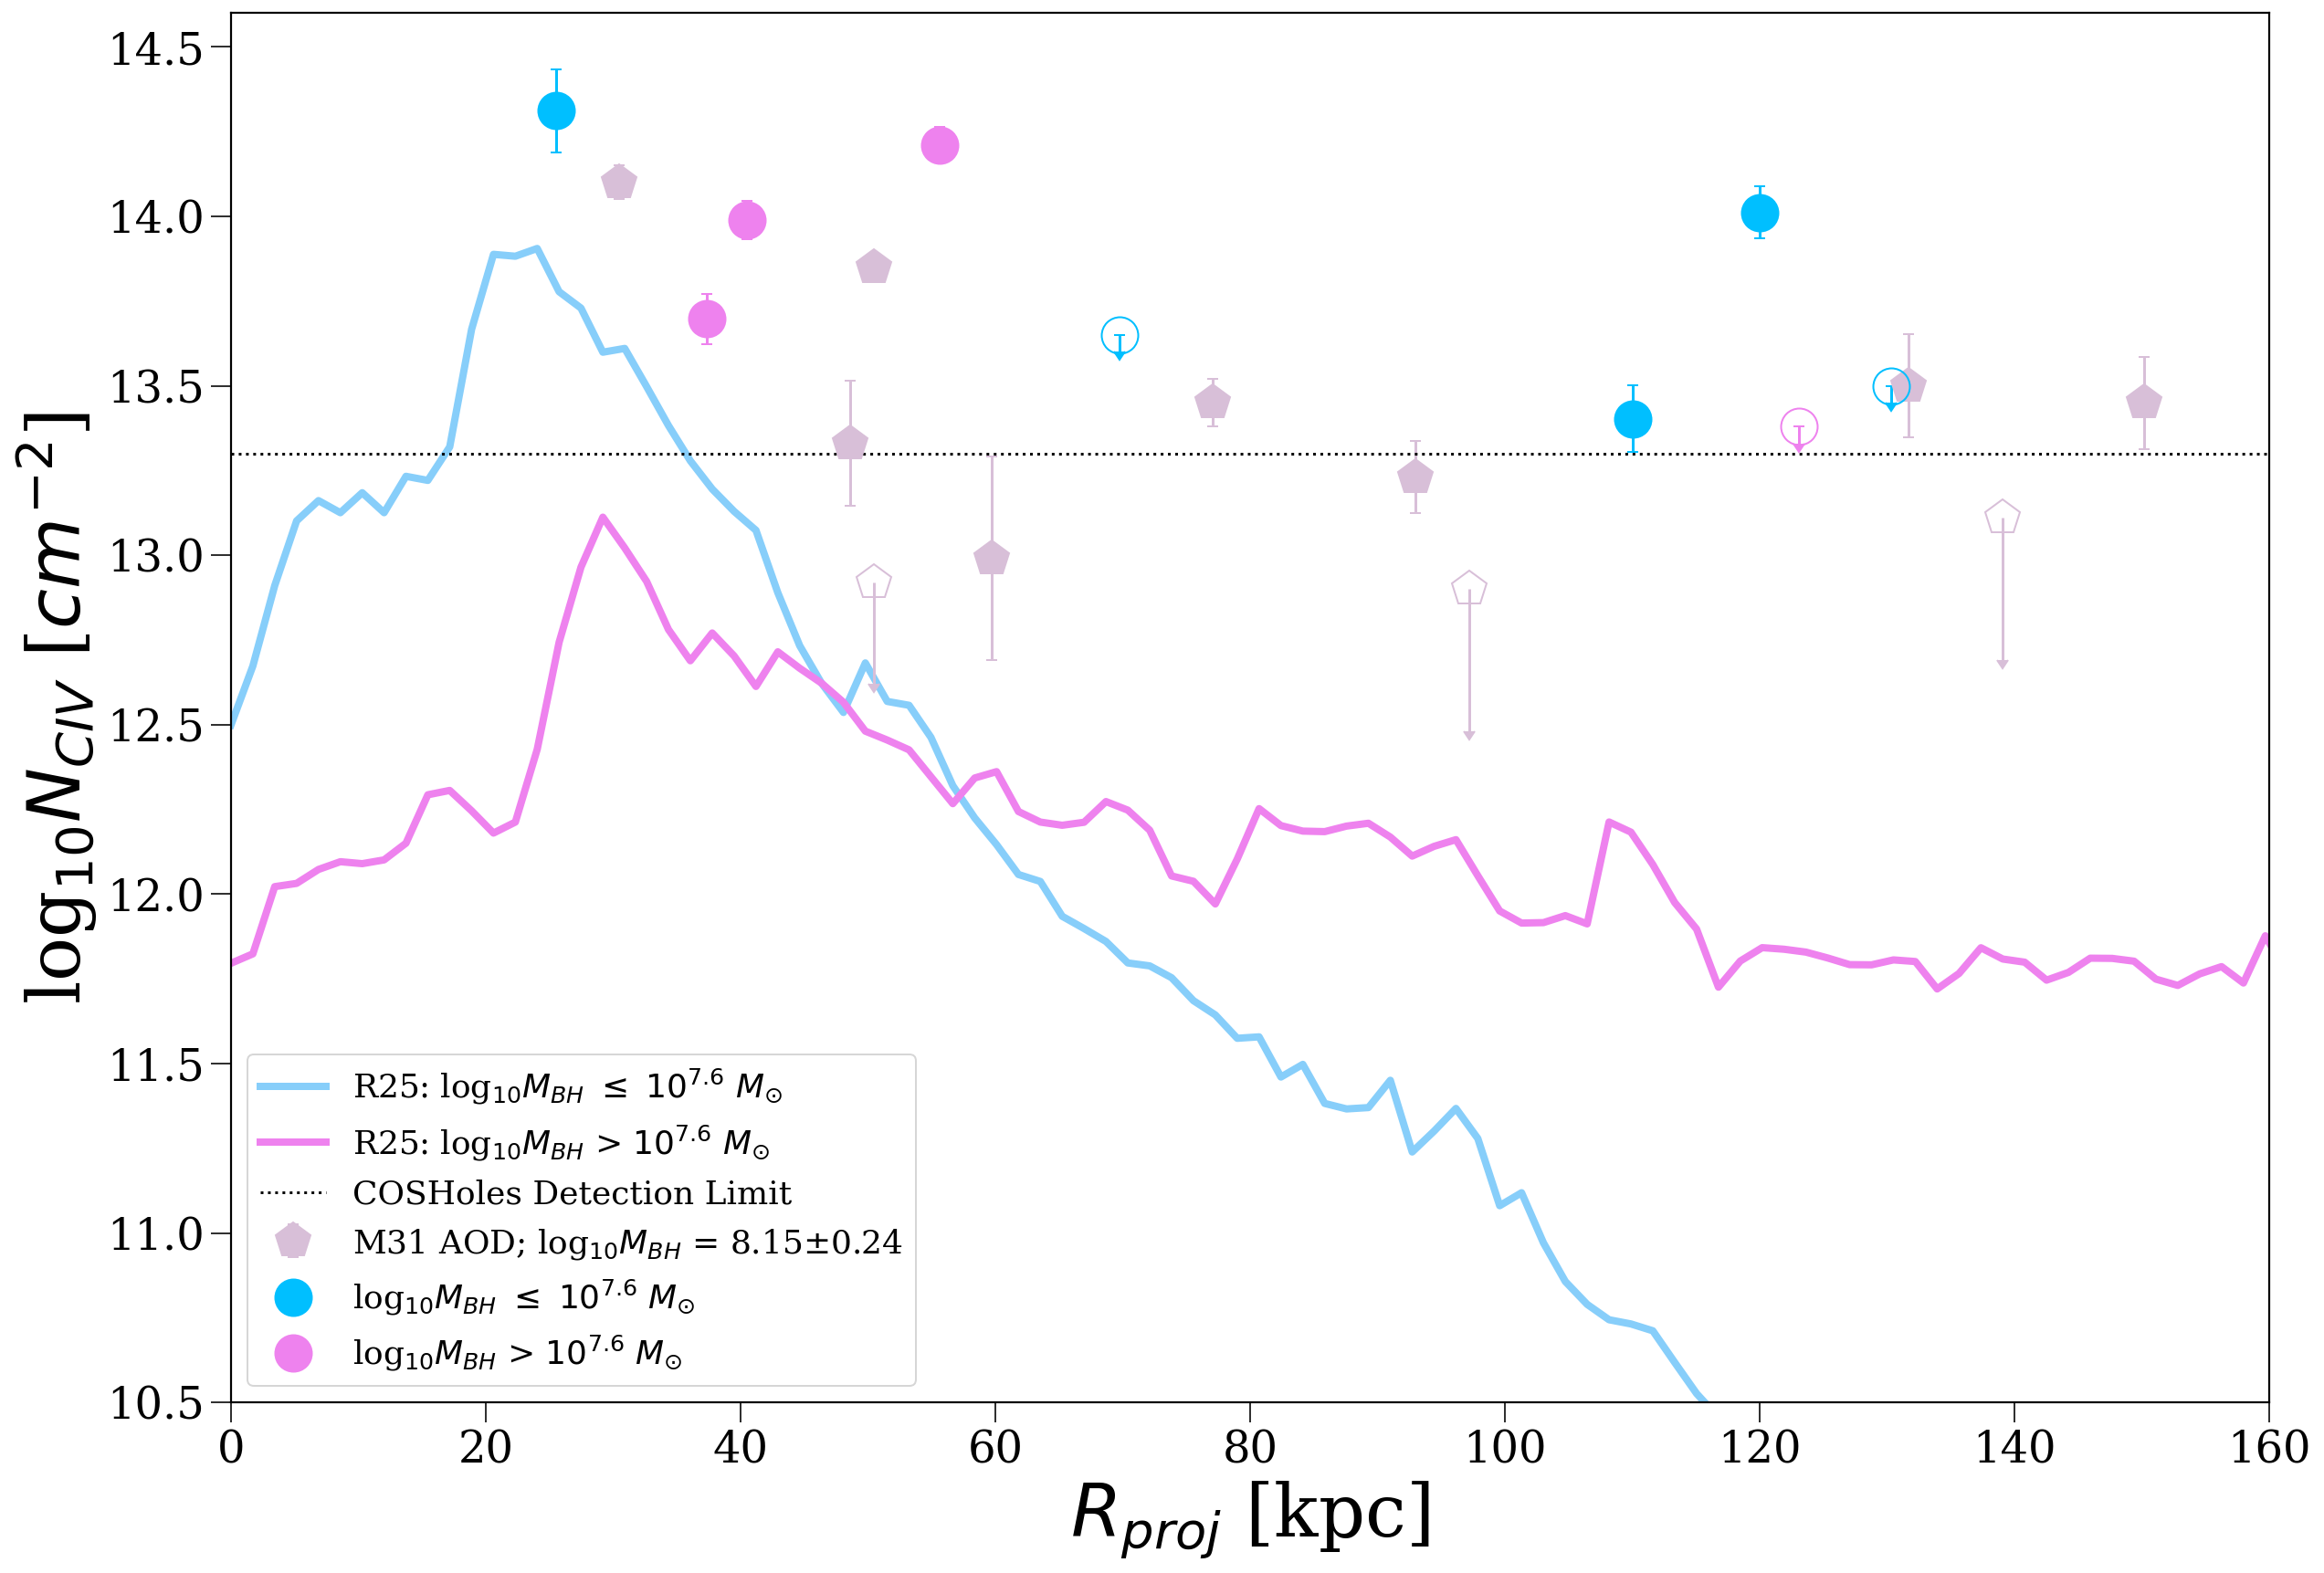

In [116]:
#Plotting NCIV vs Rproj 
    
fig, ax = plt.subplots()

########################################################

#R25 Simulational Data

plt.plot(R25_df_r['R25_R'],R25_df_r['R25_LMbh_civ'], c = 'lightskyblue', linewidth = 4, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$')
plt.plot(R25_df_r['R25_R'],R25_df_r['R25_HMbh_civ'], c = 'violet', linewidth = 4, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$')
   
########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 , used lightgrey before 

##### M31 Detections (Sums) 
plt.errorbar (amiga_2_det_sum['Rad'], amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = 'thistle', 
              marker="p", markersize=20, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24', ls='none')

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_2_up_sum['Rad'], amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = 'thistle', 
              marker="p",mfc='none',markersize=20, ls='none')

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=3, fontsize=18)
ax.set_xlabel(r"$R_{proj}$ [kpc]", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
ax.set_ylim(10.5, 14.6)
ax.set_xlim(0, 160)
plt.show()

<>:10: DeprecationWarning: invalid escape sequence \l
<>:12: DeprecationWarning: invalid escape sequence \o
<>:21: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \l
<>:12: DeprecationWarning: invalid escape sequence \o
<>:21: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \l
<>:12: DeprecationWarning: invalid escape sequence \o
<>:21: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/3824129900.py:10: DeprecationWarning: invalid escape sequence \l
  label = 'R25: log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/3824129900.py:12: DeprecationWarning: invalid escape sequence \o
  label = 'R25: log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/3824129900.py:21: DeprecationWarning: invalid escape sequence \p

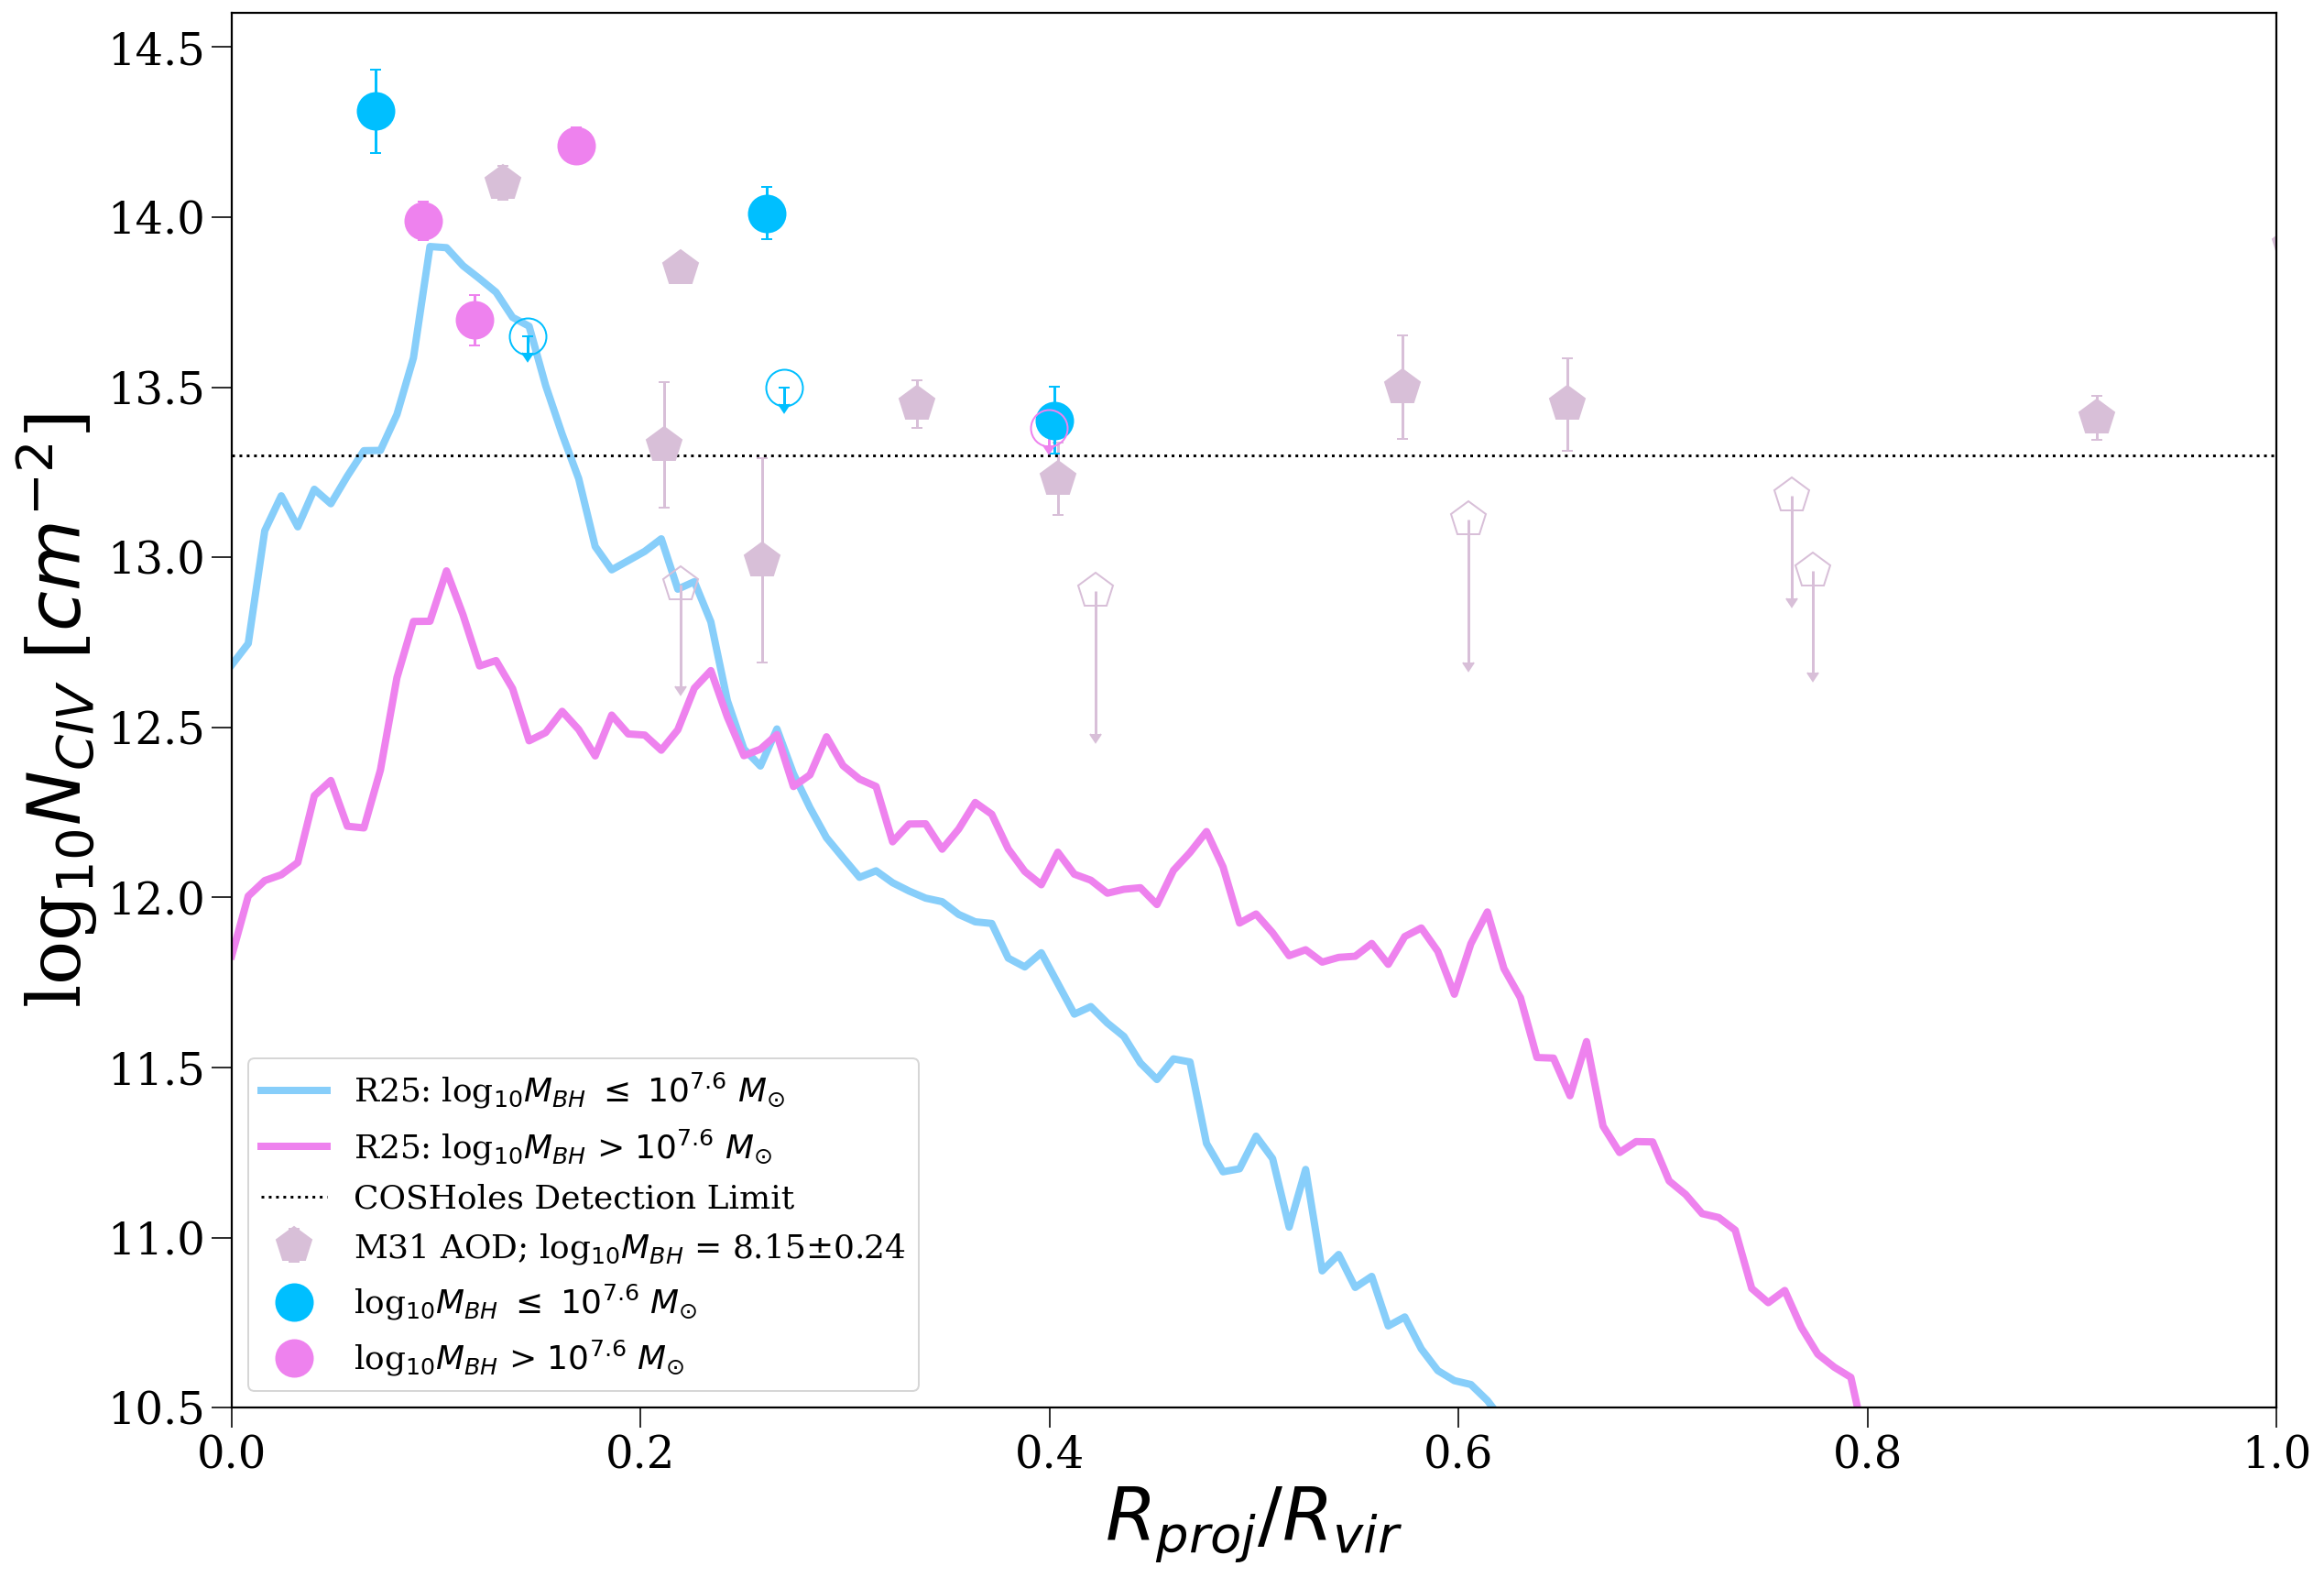

In [119]:
#Plotting NCIV vs Rproj/Rvir

fig, ax = plt.subplots()

########################################################

#R25

plt.plot(R25_df_rr['R25_RpRv'],R25_df_rr['R25_LMbh_civ'], c = 'lightskyblue', linewidth = 4, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$')
plt.plot(R25_df_rr['R25_RpRv'],R25_df_rr['R25_HMbh_civ'], c = 'violet', linewidth = 4, ls = '-',
         label = 'R25: log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = 'thistle', 
              marker="p", markersize=20, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24', ls='none')

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = 'thistle', 
              marker="p",mfc='none',markersize=20, ls='none')

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=3, fontsize=18)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
ax.set_ylim(10.5, 14.6)
ax.set_xlim(0, 1)
plt.show()

In [174]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the sum values 
r25_sum = {'QSO': ['J1101', 'J1159', 'J1249', 'J1051', 'J1123', 'J0246'],
           'R': [R25_df_r['R25_R'][64], R25_df_r['R25_R'][22], R25_df_r['R25_R'][15], R25_df_r['R25_R'][23], 
                R25_df_r['R25_R'][70], R25_df_r['R25_R'][32]],
           #'RR': [],
           'medianCIV': [R25_df_r['R25_LMbh_civ'][64], R25_df_r['R25_HMbh_civ'][22], R25_df_r['R25_LMbh_civ'][15], 
                        R25_df_r['R25_HMbh_civ'][23], R25_df_r['R25_LMbh_civ'][70], R25_df_r['R25_HMbh_civ'][32]]
           #'medianCIVRR': []
          }
R25_sum = pd.DataFrame(data=r25_sum)

In [175]:
#New larger df with R25 values included 
R25_sum_ch = pd.merge(sum_ch, R25_sum, on="QSO")
R25_sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,N,sigN,b,sigb,vel,sigvel,comp,uplim,R,medianCIV
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1,109.898990,10.731944
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1,37.777778,12.770623
2,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1,25.757576,13.777617
3,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1,39.494949,12.702890
4,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1,120.202020,10.397790
5,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1,54.949495,12.346426


In [180]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the uplim values 

r25_uplim = {'QSO': ['J1220', 'J1222', 'J1235'],
               'R': [R25_df_r['R25_R'][40], R25_df_r['R25_R'][76], R25_df_r['R25_R'][72]],
               #'RR': [],
               'medianCIV': [R25_df_r['R25_LMbh_civ'][40], R25_df_r['R25_LMbh_civ'][76], R25_df_r['R25_HMbh_civ'][72]]
               #'medianCIVRR': []
            }
R25_up = pd.DataFrame(data=r25_uplim)

In [179]:
#New larger df with R25 values included 
R25_up_ch = pd.merge(up_ch, R25_up, on="QSO")
R25_up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,N,sigN,b,sigb,vel,sigvel,comp,uplim,R,medianCIV
0,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,13.65,0.05,0.0,0.0,0.0,0.0,1,0,68.686869,11.860433
1,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,13.50,0.05,0.0,0.0,0.0,0.0,1,0,130.505051,10.036282
2,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,13.38,0.05,0.0,0.0,0.0,0.0,1,0,123.636364,11.829087


#### SUMMED VALUES (DET)

In [181]:
#For the actual stats part 
#Need these things in arrays to make it easier to run through the function 
R25_sum_medCIV = np.array(R25_sum_ch['medianCIV'])
#R25_sum_medCIVRR = np.array(R25_sum_ch['medianCIVRR'])
sum_civ = np.array(E_sum_ch['N'])

In [182]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (R25_sum_ch["MBH"] <= 7.6), (R25_sum_ch["MBH"] > 7.6)


#For the Rproj plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(R25_sum_medCIV, sum_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj Calculations in {label}: {(std*100)[mask]}')

Sigma values for Rproj Calculations in Low MBH Sample: [267.10563625  53.37062377 361.42096593]
Sigma values for Rproj Calculations in High MBH Sample: [ 92.63767761 128.7110272  186.45735999]


#### UPPER LIMITS VALUES (NON-DET)

In [183]:
#Need these things in arrays to make it easier to run through the function 
R25_up_medCIV = np.array(R25_up_ch['medianCIV'])
#E_up_medCIVRR = np.array(E_up_ch['medianCIVRR'])
up_civ = np.array(R25_up_ch['N'])

In [184]:
#Finding the sigma values and using the masks to separate values into low and high sample

low_mask, high_mask = (R25_up_ch["MBH"] <= 7.6), (R25_up_ch["MBH"] > 7.6)


#For the Rproj plot 
for mask, label in zip([low_mask, high_mask], [r"Low MBH Sample", 
                                               r"High MBH Sample"]):
    var = variance(R25_up_medCIV, up_civ)
    std = np.sqrt(var)
    
    print(f'Sigma values for Rproj Calculations in {label}: {(std*100)[mask]}')

Sigma values for Rproj Calculations in Low MBH Sample: [178.95672735 346.37181777]
Sigma values for Rproj Calculations in High MBH Sample: [155.09128841]


## Prep for Discussion Simulation Plots (Averages) - Publication Plots in CIV+Lit_Analysis.ipynb

### R25

<>:10: DeprecationWarning: invalid escape sequence \l
<>:19: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \l
<>:19: DeprecationWarning: invalid escape sequence \p
<>:10: DeprecationWarning: invalid escape sequence \l
<>:19: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/266736130.py:10: DeprecationWarning: invalid escape sequence \l
  c = 'mediumpurple', linewidth = 4, ls = '-', label = 'R25: $10^{6.6}$ $\leq$ log$M_{BH}$ $\leq$ $10^{8.6}$ $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/266736130.py:19: DeprecationWarning: invalid escape sequence \p
  marker="p", markersize=20, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24', ls='none')


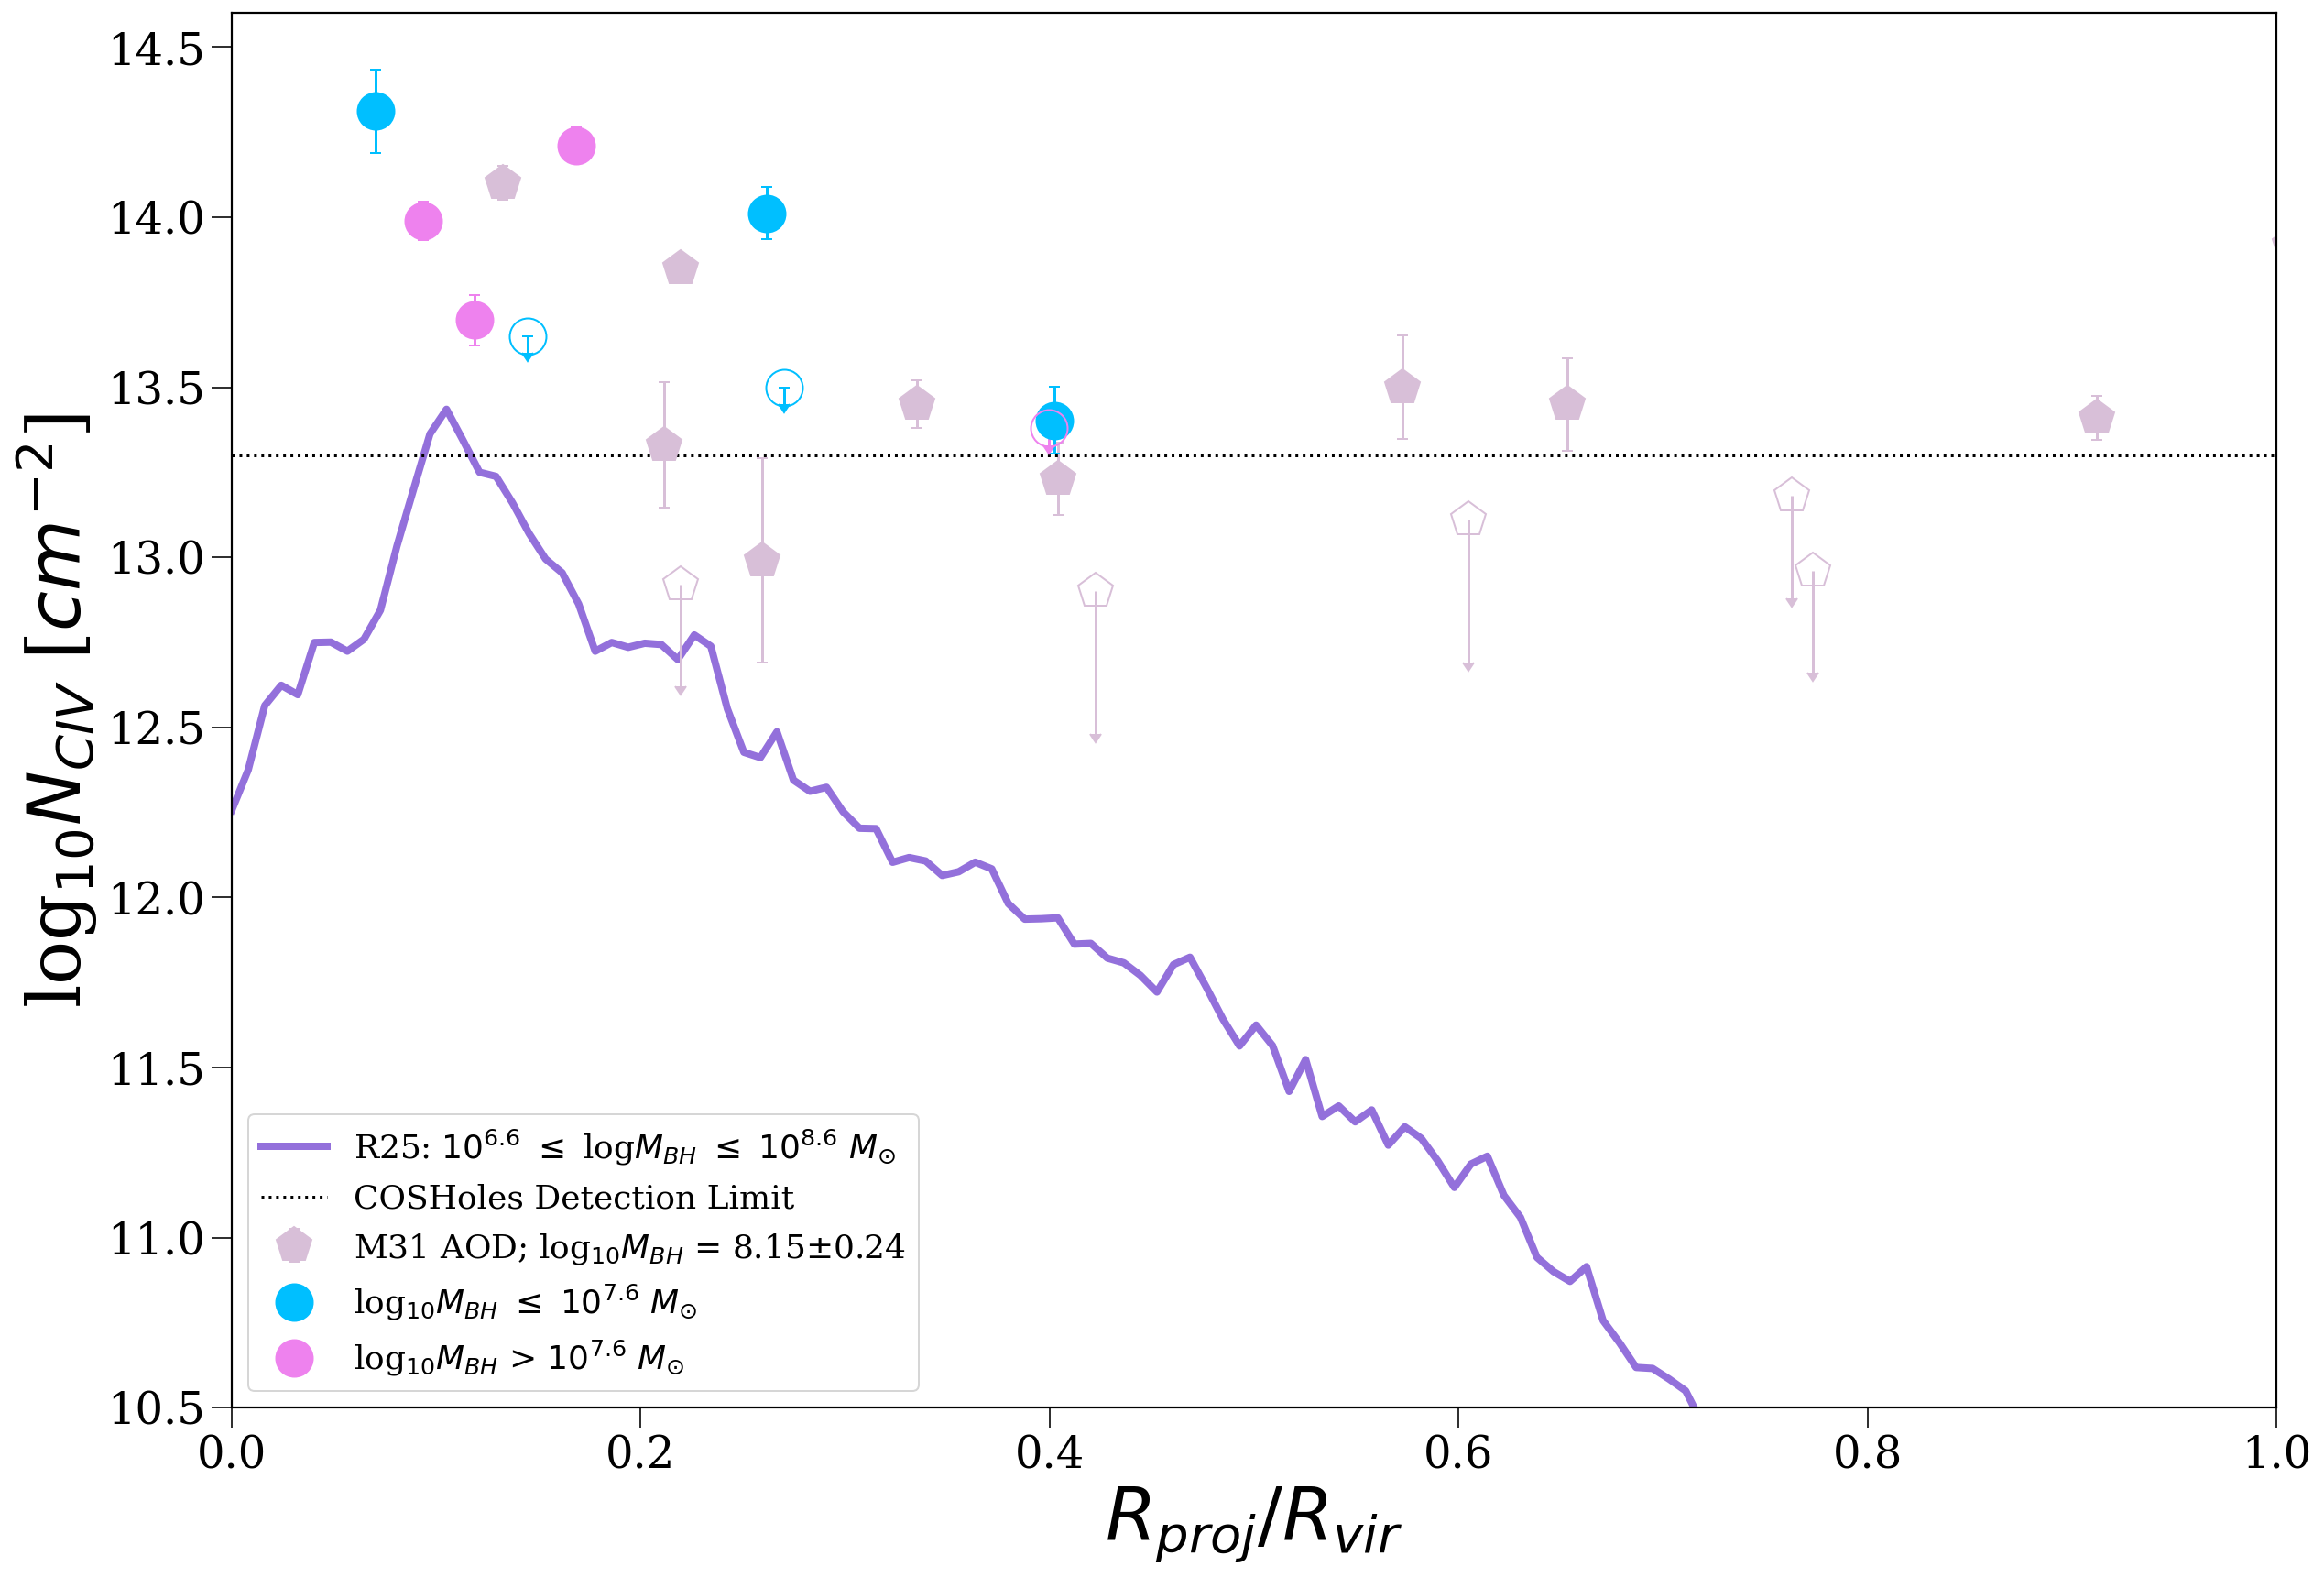

In [120]:
#Plotting NCIV vs Rproj/Rvir

fig, ax = plt.subplots()

########################################################

#R25

plt.plot((R25_df_rr['R25_RpRv'] + R25_df_rr['R25_RpRv'])/2, (R25_df_rr['R25_LMbh_civ']+ R25_df_rr['R25_HMbh_civ'])/2, 
         c = 'mediumpurple', linewidth = 4, ls = '-', label = 'R25: $10^{6.6}$ $\leq$ log$M_{BH}$ $\leq$ $10^{8.6}$ $M_{\odot}$')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = 'thistle', 
              marker="p", markersize=20, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24', ls='none')

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = 'thistle', 
              marker="p",mfc='none',markersize=20, ls='none')

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=3, fontsize=18)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
ax.set_ylim(10.5, 14.6)
ax.set_xlim(0, 1)
plt.show()

### EAGLE (Slightly Different Data to make more accurate average)

In [121]:
df_rr_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.6.6_7.6.dat",sep="\s+")
df_rr_new_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.7.6_8.6.dat",sep="\s+")

df_r_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.6.6_7.6.dat",sep="\s+")
df_r_new_high = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.7.6_8.6.dat",sep="\s+")

<>:1: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \s
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/2210995085.py:1: DeprecationWarning: invalid escape sequence \s
  df_rr_new_low = pd.read_table("/Users/samgarza/Documents/COS-Holes/EAGLE.COS-Holes/profile_coll_EAGLE.halo.list.CIV_median.MBH56_86_3bins.MS102_109.6.6_7.6.dat",sep="\s+")
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35

<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
<>:13: DeprecationWarning: invalid escape sequence \l
<>:22: DeprecationWarning: invalid escape sequence \p
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/2387269364.py:13: DeprecationWarning: invalid escape sequence \l
  color = 'mediumpurple', lw = 3, label = 'EAGLE:  $10^{6.6}$ $\leq$ log$M_{BH}$ $\leq$ $10^{8.6}$ $M_{\odot}$')
/var/folders/cm/j7lkwsrd7jzb97p6qnw8qmgr0000gn/T/ipykernel_35878/2387269364.py:22: DeprecationWarning: invalid escape sequence \p
  marker="p", markersize=20, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24', ls='none')


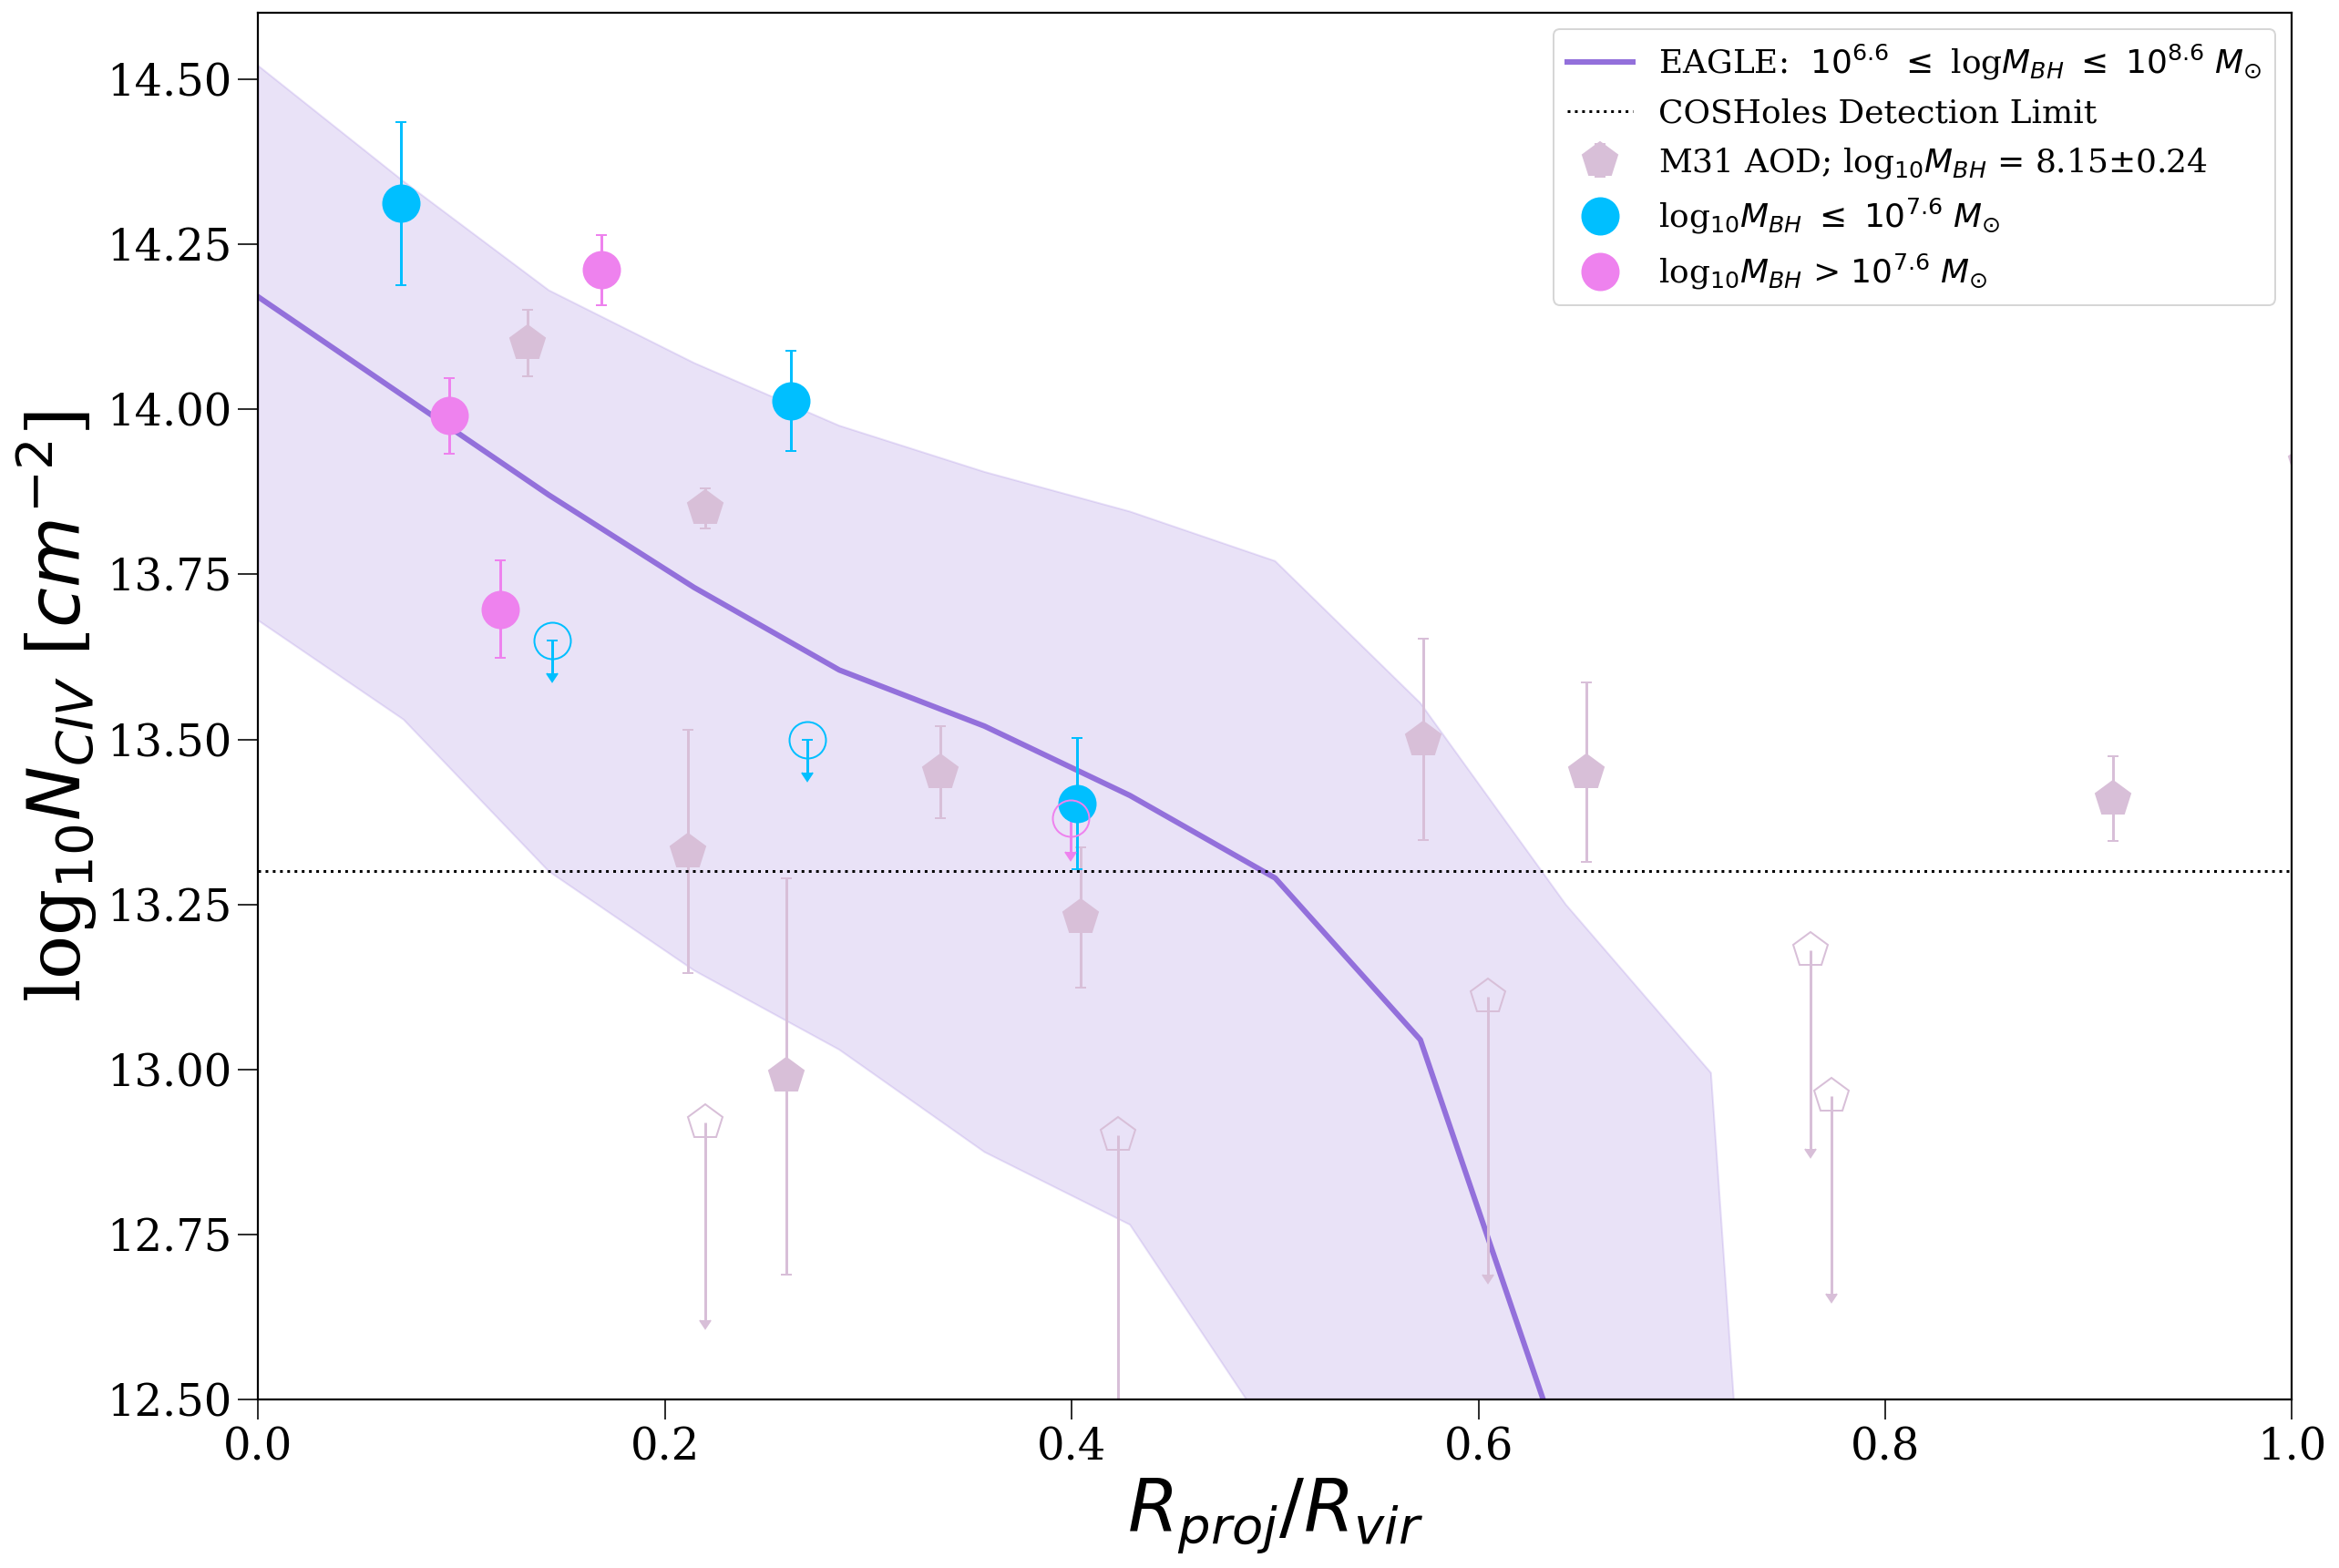

In [122]:
#Plotting NCIV vs Rproj/Rvir

fig, ax = plt.subplots()

########################################################

#EAGLE

plt.fill_between((df_rr_new_low['#R/R200'] + df_rr_new_high['#R/R200'])/2, 
                 (df_rr_new_low['16percentile'] + df_rr_new_high['16percentile'])/2, 
                 (df_rr_new_low['84percentile'] + df_rr_new_high['84percentile'])/2, alpha = 0.2, color = 'mediumpurple')
plt.plot((df_rr_new_low['#R/R200'] + df_rr_new_high['#R/R200'])/2, (df_rr_new_low['median'] + df_rr_new_high['median'])/2, 
         color = 'mediumpurple', lw = 3, label = 'EAGLE:  $10^{6.6}$ $\leq$ log$M_{BH}$ $\leq$ $10^{8.6}$ $M_{\odot}$')

########################################################

# M31 information from Project AMIGA: 
# BH Mass: https://arxiv.org/pdf/1707.04001.pdf = 8.15+/- 0.24 

##### M31 Detections (Sums) 
plt.errorbar (amiga_det_RRvir, amiga_2_det_sum['logN'], yerr=amiga_2_det_sum['sum_elogN'],capsize = 3, c = 'thistle', 
              marker="p", markersize=20, label='M31 AOD; log$_{10}M_{BH}$ = 8.15$\pm$0.24', ls='none')

##### M31 Upper Limits (Sums)
plt.errorbar (amiga_up_RRvir, amiga_2_up_sum['logN'], yerr=amiga_2_up_sum['sum_elogN'],uplims=True, c = 'thistle', 
              marker="p",mfc='none',markersize=20, ls='none')

########################################################

plt.axhline(13.3, c='k', ls=':', label='COSHoles Detection Limit')

for mask, colour, label in zip([low_mask, high_mask], ["deepskyblue", "violet"], 
                               [r"log$_{10}M_{BH}$ $\leq$ $10^{7.6}$ $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > $10^{7.6}$ $M_{\odot}$"]):
    
    ax.errorbar(sum_ch["Rproj/Rvir"][mask], sum_ch['N'][mask],yerr=sum_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, label=label, ls='none')
    
    ax.errorbar(up_ch["Rproj/Rvir"][mask], up_ch['N'][mask], yerr=up_ch['sigN'][mask], 
                capsize = 3, c = colour, marker=".", markersize=40, ls='none', uplims=True, mfc='none')

ax.legend(loc=1, fontsize=18)
ax.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=40)
ax.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=40)
ax.set_ylim(12.5, 14.6)
ax.set_xlim(0, 1)
plt.show()

#### Sigma Calculations

In [187]:
rr_sum = (df_rr_new_low['#R/R200'] + df_rr_new_high['#R/R200'])/2
rr_med_sum = (df_rr_new_low['median'] + df_rr_new_high['median'])/2

In [188]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the sum values 
eagle_avg_sum = {'QSO': ['J1101', 'J1159', 'J1249', 'J1051', 'J1123', 'J0246'],
           'RR': [rr_sum[0], rr_sum[1], rr_sum[4], rr_sum[5], rr_sum[6], rr_sum[7]],
           #'R': [],
           'medianCIVRR': [rr_med_sum[0], rr_med_sum[1], rr_med_sum[4], rr_med_sum[5], rr_med_sum[6], rr_med_sum[7]]
           #'medianCIV': []
          }
E_avg_sum = pd.DataFrame(data=eagle_avg_sum)

In [190]:
#New larger df with R25 values included 
E_avg_sum_ch = pd.merge(sum_ch, E_avg_sum, on="QSO")
E_avg_sum_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,N,sigN,b,sigb,vel,sigvel,comp,uplim,RR,medianCIVRR
0,NGC3489,J1101,0.002258,676.9,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1,0.00000,14.170
1,NGC4026,J1159,0.003286,985.1,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1,0.07143,14.020
2,NGC4736,J1249,0.001027,307.8,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1,0.28570,13.605
3,NGC3414,J1051,0.004900,1469.8,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1,0.35710,13.520
4,NGC3627,J1123,0.002430,721.0,6.920,0.048,10.84,12.455645,0.536,117.031587,...,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1,0.42860,13.415
5,NGC1097,J0246,0.004240,1271.1,8.140,0.090,10.50,12.029020,0.766,24.205849,...,14.211000,0.053000,54.100,7.973,18.210,5.687,1,1,0.50000,13.290


In [191]:
#Making a df of impact parameters and N values to add to previous made dfs

#For the uplim values 

E_avg_uplim = {'QSO': ['J1220', 'J1222', 'J1235'],
               'RR': [rr_sum[2], rr_sum[3], rr_sum[8]],
               #'R': [],
               'medianCIVRR': [rr_med_sum[2], rr_med_sum[3], rr_med_sum[8]]
               #'medianCIVR': []
            }
E_avg_up = pd.DataFrame(data=E_avg_uplim)

In [193]:
#New larger df with R25 values included 
E_avg_up_ch = pd.merge(up_ch, E_avg_up, on="QSO")
E_avg_up_ch

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,N,sigN,b,sigb,vel,sigvel,comp,uplim,RR,medianCIVRR
0,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,13.65,0.05,0.0,0.0,0.0,0.0,1,0,0.1429,13.870
1,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.0,...,13.50,0.05,0.0,0.0,0.0,0.0,1,0,0.2143,13.730
2,NGC4564,J1235,0.003809,1141.90,7.940,0.145,10.40,11.938382,-1.988,0.0,...,13.38,0.05,0.0,0.0,0.0,0.0,1,0,0.5714,13.045


##### SUMMED VALUES (DET)

In [200]:
#Actual Stats part 

#Need these things in arrays to make it easier to run through the function 

#E_avg_sum_medCIV = np.array(E_avg_sum_ch['medianCIV'])
E_avg_sum_medCIVRR = np.array(E_avg_sum_ch['medianCIVRR'])
sum_civ = np.array(E_avg_sum_ch['N'])

In [201]:
#Finding the sigma values and using the masks to separate values into low and high sample

#For the Rproj/Rvir plot 

var = variance(E_avg_sum_medCIVRR, sum_civ)
std = np.sqrt(var)
    
print('Sigma values for Rproj/Rvir Calculations:', (std*100))

Sigma values for Rproj/Rvir Calculations: [76.7      32.3      70.632331 47.       59.7      92.1     ]


##### UPPER LIMITS (NON-DET)

In [203]:
#Actual Stats part 

#Need these things in arrays to make it easier to run through the function 

#E_avg_sum_medCIV = np.array(E_avg_sum_ch['medianCIV'])
E_avg_up_medCIVRR = np.array(E_avg_up_ch['medianCIVRR'])
sum_civ = np.array(E_avg_up_ch['N'])

In [204]:
#For the Rproj/Rvir plot 

var = variance(E_avg_up_medCIVRR, sum_civ)
std = np.sqrt(var)
    
print('Sigma values for Rproj/Rvir Calculations:', std*100)

Sigma values for Rproj/Rvir Calculations: [22.  23.  33.5]
